In [1]:
from hera_stats.bias_jackknife import bias_jackknife, bandpower
from hera_pspec import UVPSpec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.interpolate import interp1d
from scipy.stats import norm, multivariate_normal, gaussian_kde
from scipy.linalg import block_diag, LinAlgError
from scipy.special import comb
import time
from more_itertools import powerset
from itertools import combinations
from matplotlib import cm
from copy import deepcopy
from matplotlib.ticker import AutoMinorLocator

default_hist_kwargs = {"histtype": "step", "bins": "auto", "density": True}

# The next few cells just check that the code works as expected in a few cases (basically soft unit tests)

In [2]:
bp = bandpower()

### Check that we got gaussian draws about the correct mean

bandpower mean: 1
bandpower bias: 0
bandpower std: 1
bandpower estimated mean: 1.0008639810946718
bandpower estimated std: 0.9995508267213392


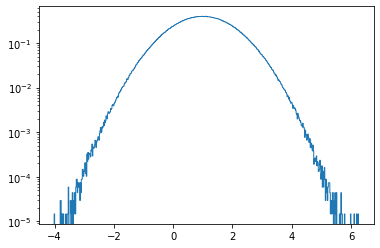

In [3]:
print(f"bandpower mean: {bp.mean}")
print(f"bandpower bias: {bp.bias}")
print(f"bandpower std: {bp.std}")

est_mean = np.mean(bp.bp_draws)
est_std = np.sqrt(np.var(bp.bp_draws))
print(f"bandpower estimated mean: {est_mean}")
print(f"bandpower estimated std: {est_std}")

_, _, _ = plt.hist(bp.bp_draws.flatten(), **default_hist_kwargs)
plt.yscale("log")

### Do a new draw with a bias

bandpower mean: 1
bandpower bias: 1
bandpower std: 1
bandpower estimated mean: 2.0003594677889724
bandpower estimated std: 0.9997821497033792


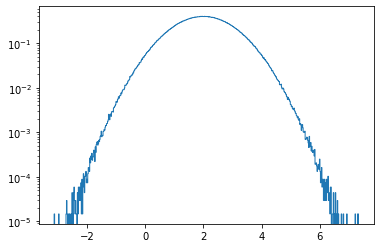

In [4]:
bp = bandpower(bias=1)
print(f"bandpower mean: {bp.mean}")
print(f"bandpower bias: {bp.bias}")
print(f"bandpower std: {bp.std}")

est_mean = np.mean(bp.bp_draws)
est_std = np.sqrt(np.var(bp.bp_draws))
print(f"bandpower estimated mean: {est_mean}")
print(f"bandpower estimated std: {est_std}")

_, _, _ = plt.hist(bp.bp_draws.flatten(), **default_hist_kwargs)
plt.yscale("log")

### Do a draw with a few different scales

/opt/miniconda3/envs/hera_stats/lib/python3.10/site-packages/hera_stats/bias_jackknife.py:58: UserWarning: Casting std parameter as an array
  warnings.warn("Casting std parameter as an array")


bandpower mean: 1
bandpower bias: 1
bandpower std: [1.  1.2 0.8 1.5]
bandpower estimated mean: 1.999966052956581
bandpower estimated std: [0.99907278 1.19999282 0.80011376 1.49809971]


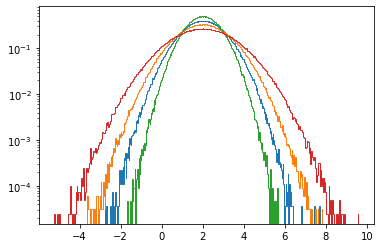

In [5]:
bp = bandpower(bias=1, std=[1, 1.2, 0.8, 1.5])
print(f"bandpower mean: {bp.mean}")
print(f"bandpower bias: {bp.bias}")
print(f"bandpower std: {bp.std}")

est_mean = np.mean(bp.bp_draws)
est_std = np.sqrt(np.var(bp.bp_draws, axis=0))
print(f"bandpower estimated mean: {est_mean}")
print(f"bandpower estimated std: {est_std}")

for ep_ind in range(4):
    _, _, _ = plt.hist(bp.bp_draws[:, ep_ind], **default_hist_kwargs)
plt.yscale("log")

### Make a jackknife object and check numerical vs. analytic posteriors. Check with a histogram

In [6]:
def hist_check(bias=1, num_draw=int(1e3), std=0.5, check=1, num_pow=2, debug=False, bias_prior_mean=0):
    bp_test = bandpower(bias=bias, num_draw=num_draw, std=std, num_pow=num_pow)
    if check == 1:
        
        title = "Analytic vs. Numerical"
        bjack_1 = bias_jackknife(bp_test, bias_prior_mean=bias_prior_mean, analytic=True)
        bjack_2 = bias_jackknife(bp_test, bias_prior_mean=bias_prior_mean, analytic=False)
    elif check == 2:
        title = "Analytic vs. Analytic"
        bjack_1 = bias_jackknife(bp_test, bias_prior_mean=bias_prior_mean, analytic=True)
        bp_test.std = np.array(num_pow*[std])
        bjack_2 = bias_jackknife(bp_test, bias_prior_mean=bias_prior_mean, analytic=True)
        
        if debug:
            print(f"params for bjack_1 in True case: {bjack_1._get_mod_var_mean_gauss_2(True, debug=True)}")
            print(f"params for bjack_2 in True case: {bjack_2._get_mod_var_mean_gauss_2(True, debug=True)}")
            print(f"params for bjack_1 in False case: {bjack_1._get_mod_var_mean_gauss_2(False, debug=True)}")
            print(f"params for bjack_2 in False case: {bjack_2._get_mod_var_mean_gauss_2(False, debug=True)}")
            return
    else:
        raise ValueError("check keyword can only take values 1 or 2")

    fig, ax = plt.subplots(figsize=(8, 4), ncols=2)
    print(bjack_1.num_hyp)
    
    post_diffs = (bjack_1.post - bjack_2.post)
    frac_post_diffs = post_diffs / (0.5 * (bjack_1.post + bjack_2.post))

    
    _, _, _ = ax[0].hist(post_diffs.flatten(), **default_hist_kwargs)
    _, _, _ = ax[1].hist(frac_post_diffs.flatten(), **default_hist_kwargs)
    ax[0].set_xlabel("Absolute Difference")
    ax[1].set_xlabel("Fractional Difference")
    fig.suptitle(title)

    print(f"max fractional difference is {np.amax(np.abs(frac_post_diffs))}")
    print(f"max absolute difference is {np.amax(np.abs(post_diffs))}")

8
max fractional difference is 1.1667180686326514e-13
max absolute difference is 2.1094237467877974e-15


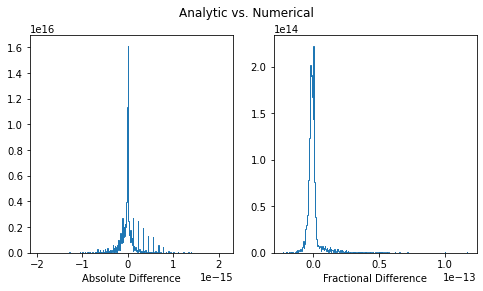

In [7]:
hist_check(num_pow=3)

8
max fractional difference is 1.046979451899688e-13
max absolute difference is 2.3869795029440866e-15


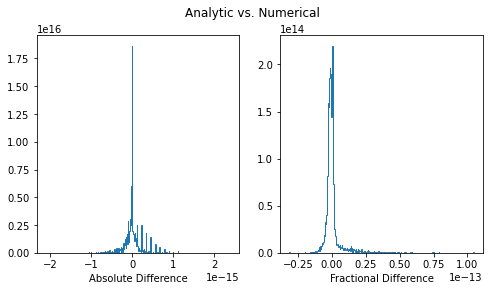

In [8]:
hist_check(num_pow=3, bias_prior_mean=1)

16
max fractional difference is 7.296570263771182e-12
max absolute difference is 3.481659405224491e-13


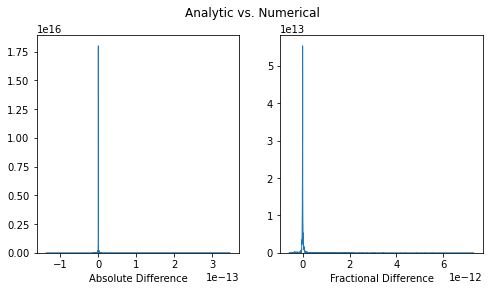

In [9]:
hist_check(std=[0.5, 0.5, 0.5, 0.5], check=1, num_pow=4)

16
max fractional difference is 1.605681453628144e-11
max absolute difference is 5.834915883795588e-13


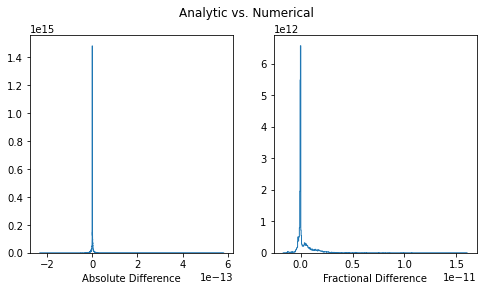

In [10]:
hist_check(std=[0.5, 0.7, 0.1, 0.5], check=1, num_pow=4)

## Do a bigger draw and histogram the posteriors - compare biased vs. unbiased

In [11]:
bp_big_draw = bandpower(bias=0, num_draw=int(1e7))
bjack_big_draw = bias_jackknife(bp_big_draw, analytic=True)
bp_big_draw_bias = bandpower(bias=5, num_draw=int(1e7))
bjack_big_draw_bias = bias_jackknife(bp_big_draw_bias, analytic=True)



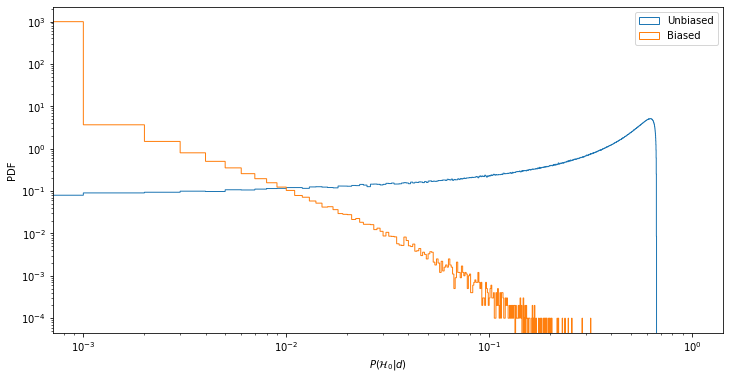

In [12]:
plt.figure(figsize=(12, 6))
plt.hist(bjack_big_draw.post[0], bins=np.linspace(0, 1, num=1001), histtype='step', density=True, label="Unbiased")
plt.hist(bjack_big_draw_bias.post[0], bins=np.linspace(0, 1, num=1001), histtype='step', density=True, label="Biased")
plt.xlabel("$P(\mathcal{H}_0|d)$")
plt.ylabel("PDF")
plt.yscale("log")
plt.xscale("log")
plt.legend()

The above plot is histogramming the posterior probability of the null hypothesis for many simulated draws of unbiased and highly biased data. We expect a strong concentration of biased data at low posterior probability and vice versa for unbiased data.

# Library of helper functions. Most of these just wrap each other.

In [13]:
def make_diag_bpc_list(num_pow, var):
    bpc_list = []
    for epoch_on in powerset(np.arange(num_pow, dtype=int)):
        elems = np.zeros(num_pow)
        elems[np.array(epoch_on, dtype=int)] = var
        bpc_list.append(np.diag(elems))
        
    return(bpc_list)

def make_cov_list(mode, bias_prior_std, num_pow):
    bpc_shape = [num_pow, num_pow]
    var = bias_prior_std**2
    
    if mode == 'ternary':
        bpc_list = [np.zeros(bpc_shape), var * np.eye(num_pow), var * np.ones(bpc_shape)]
    else:
        bpc_list = make_diag_bpc_list(num_pow, var)
        
    return(bpc_list)

def make_sim_from_bpc_list(bpc_list, num_pow, num_draw, mean, std, bias_prior_mean):
    sim_list = []
    for bpc_ind, bpc in enumerate(bpc_list):
        if bpc_ind > 0:
            bpc_diags = np.diag(bpc)
            bias_mean_use = np.where(bpc_diags != 0, bias_prior_mean, 0)
        else:
            bias_mean_use = np.zeros(num_pow)
        bias = np.random.multivariate_normal(mean=bias_mean_use, cov=bpc, size=num_draw)
        sim = bandpower(mean=mean, bias=bias, std=std, num_pow=num_pow, num_draw=num_draw)
        sim_list.append(sim)
    return(sim_list)
        

def make_sim_list(mode, num_pow=3, bp_prior_mean=0.1, bp_prior_std=0.05, std=1, bias_prior_std=10,
                  num_draw=int(1e6), bias_prior_mean=0):
    valid_modes = ['ternary', 'diagonal']
    assert mode in valid_modes, f"mode must be in one of {valid_modes}"
    
    num_draw = int(num_draw)
    
    mean = np.random.normal(loc=bp_prior_mean, scale=bp_prior_std, size=(num_draw, num_pow))
    bpc_list = make_cov_list(mode, bias_prior_std, num_pow)

    sim_list = make_sim_from_bpc_list(bpc_list, num_pow, num_draw, mean, std, bias_prior_mean)
    
    
    return(sim_list)

def get_jk_list(sim_list, mode, num_pow=3, bp_prior_mean=0.1, bp_prior_std=0.05, std=1, bias_prior_std=10,
                num_draw=int(1e6), hyp_prior=None, bias_prior_mean=0):

    jk_list = []
    for sim in sim_list:
        jk = bias_jackknife(sim, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                            bias_prior_mean=bias_prior_mean,
                            bias_prior_std=bias_prior_std, mode=mode, hyp_prior=hyp_prior)
        
        jk_list.append(jk)
    
    return(jk_list)


def get_mix_sim_jk(sim_list, hyp_prior, bp_prior_mean=0.1, bp_prior_std=0.05, mode='diagonal',
                   bias_prior_std=10, bias_prior_mean=0, num_draw=int(1e4)):
    dat_list = [sim.bp_draws.T for sim in sim_list]
    trial = np.random.multinomial(1, hyp_prior, size=num_draw).argmax(axis=1)
    mixdat = np.choose(trial, dat_list).T
    
    mix_sim = deepcopy(sim_list[0])
    mix_sim.bp_draws = np.copy(mixdat)
    
    jk = bias_jackknife(mix_sim, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std, mode=mode,
                        bias_prior_std=bias_prior_std, hyp_prior=hyp_prior, bias_prior_mean=bias_prior_mean)
    
    
    return(mix_sim, jk)

def get_mut_info_from_mix(jk):
    logs = np.where(jk.evid > 0, -np.log2(jk.evid), 0)
    Hd = logs.mean()
    Hcond = jk.sum_entropy
    
    if np.any(np.isnan(logs)):
        print("Some nans in logs")
        
    if np.any(np.isinf(logs)):
        print("Some infs in logs")
    mut_info = Hd-Hcond
    
    return(mut_info)

def get_mut_info(mode, num_pow=3, bp_prior_mean=0.1, bp_prior_std=0.05, std=1, bias_prior_std=10,
                 num_draw=int(1e6), hyp_prior=None, bias_prior_mean=0):
    
    num_draw = int(num_draw)
    sim_list = make_sim_list(mode, num_pow=num_pow, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                             std=std, bias_prior_std=bias_prior_std, num_draw=num_draw,
                             bias_prior_mean=bias_prior_mean)
    if hyp_prior is None:
        num_hyp = len(sim_list)
        hyp_prior = np.ones(num_hyp) / num_hyp
    
    mix_sim, jk = get_mix_sim_jk(sim_list, hyp_prior, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                                 mode=mode, bias_prior_std=bias_prior_std,
                                 bias_prior_mean=bias_prior_mean, num_draw=num_draw)
    
    
    mut_info = get_mut_info_from_mix(jk)
    
    return(mut_info)
    
    

def mut_info_wrap(mode, num_pow=4, bp_prior_mean=0, bp_prior_std=0, std=1,
                  bias_prior_means=np.linspace(0, 10, num=100),
                  bias_prior_stds=np.logspace(-3, 3, num=100), num_draw=int(1e6), hyp_prior=None):

    mut_info_arr = np.zeros([len(bias_prior_stds), len(bias_prior_means)])
    num_bps = len(bias_prior_stds)
    num_bpms = len(bias_prior_means)
    print(f"Iterating through {num_bps} prior widths and {num_bpms} prior means")
    print("width index changes the slowest")
    for bps_ind, bias_prior_std in enumerate(bias_prior_stds):
        print(f"Current width iteration: {bps_ind}")
        for bpm_ind, bias_prior_mean in enumerate(bias_prior_means):
            mut_info = get_mut_info(mode, num_pow=num_pow, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                                    bias_prior_std=bias_prior_std, num_draw=num_draw, std=std, hyp_prior=hyp_prior,
                                    bias_prior_mean=bias_prior_mean)
            mut_info_arr[bps_ind, bpm_ind] = mut_info
    return((bias_prior_stds, bias_prior_means, mut_info_arr))


def get_odds(jk, odds_thresh):
    max_post_ind = np.argmax(jk.post)
    odds = jk.post / jk.post[max_post_ind] 
    comp_inds = np.logical_and(odds > 1, odds < odds_thresh).flatten()
    
    conc = {"max_post_ind": max_post_ind, "comp_inds": comp_inds,
            "odds": odds[comp_inds]}
    
    return(odds, conc)
    
    
def run_jk(bp_meas, num_pow=3, bp_prior_mean=0.1, bp_prior_std=0.05, bias_prior_std=10, odds_thresh=10,
           std=1, bias_prior_mean=0, diag_only=False, print_post=False):
    bp = bandpower(bp_meas=bp_meas, simulate=False, num_pow=num_pow, num_draw=1, std=std)

    modes = ["ternary", "diagonal"]

        
    concs = []
    odds_list = []
    for mode_ind, mode in enumerate(modes):
        if diag_only and (mode != "diagonal"):
            continue
        jk = bias_jackknife(bp, bp_prior_mean=bp_prior_mean, bp_prior_std=bp_prior_std,
                            bias_prior_std=bias_prior_std, mode=mode, bias_prior_mean=bias_prior_mean)
        if print_post:
            print(jk.post)
        odds, conc = get_odds(jk, odds_thresh)
        odds_list.append(odds)
        concs.append(conc)
 
    return(odds_list, concs)
        
    

# Make figure 1

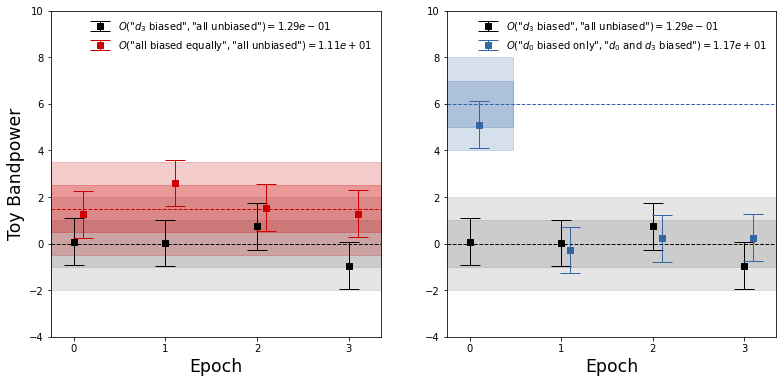

In [14]:
class int_builder_dat:
    
    def __init__(self, s=0.1, n=1, zwant=4, num_pow=4, new_draw=False, save_new=False,
                 fns=['unbiased_int_build.npy', 'bias1_int_build.npy', 'bias2_int_build.npy'],
                 zcut=0.25, seed=2727):
        self.s = s
        self.n = n
        self.zwant= zwant
        self.num_pow = num_pow
        self.new_draw = new_draw
        self.save_new = save_new
        self.fns = fns
        self.zcut = zcut
        self.seed = seed
        
        self.b1, self.b2 = self.get_b1_b2()
        self.bp_meas_unb, self.bp_meas_b1, self.bp_meas_b2 = self.get_draws()
        
    def get_b1_b2(self):
        b1 = self.zwant / np.sqrt(self.num_pow) * self.n
        b2 = self.zwant * np.sqrt(self.num_pow) * self.n
        return(b1, b2)
    
    def get_draws(self, use_seed=True):
        if use_seed:
            np.random.seed(self.seed)
        if self.new_draw:
            bp_meas_unb, bp_meas_b1, bp_meas_b2 = self.gen_new_draws()
            bps_meas = [bp_meas_unb, bp_meas_b1, bp_meas_b2]
            if self.save_new:
                for fn, bp_meas in zip(self.fns, bps_meas):
                    np.save(fn, bp_meas)
        else:
            bp_meas_unb, bp_meas_b1, bp_meas_b2 = self.load_draws()
        return(bp_meas_unb, bp_meas_b1, bp_meas_b2)

    def gen_new_draws(self):
        typical=False
        while not typical:
            bp_meas_unb = np.random.normal(loc=self.s, scale=self.n, size=self.num_pow)
            bp_meas_b1 = np.random.normal(loc=self.s + self.b1, scale=self.n, size=self.num_pow)
            bp_meas_b2 = np.random.normal(loc=[self.s + self.b2] + (self.num_pow - 1) * [self.s], scale=self.n,
                                          size=self.num_pow)
            zub = np.sqrt(self.num_pow) * np.mean(bp_meas_unb - self.s) / self.n
            zb1 = np.sqrt(self.num_pow) * np.mean(bp_meas_b1 - self.s) / self.n - self.zwant
            zb2 = np.sqrt(self.num_pow) * np.mean(bp_meas_b2 - self.s) / self.n - self.zwant
            if (np.abs(zb1) < self.zcut) and (np.abs(zb2) < self.zcut) and (np.abs(zub) < self.zcut):
                typical = True

        return(bp_meas_unb, bp_meas_b1, bp_meas_b2)

    def load_draws(self):
        bps_meas = []
        for fn in self.fns:
            bps_meas.append(np.load(fn))
        bps_meas = tuple(bps_meas)

        return(bps_meas)
    
class int_builder_plot:
    
    def __init__(self, ibd, fn="int_builder.pdf", right_xlim=1.47):
        self.ibd = ibd
        self.set_plot_params(right_xlim)
            
        self.fig, self.ax = fig, ax = plt.subplots(figsize=(13, 6), ncols=2)
        
        
        self.plot_dat()
        self.set_ax_labels()
        self.fig.savefig(fn)
        
    
    def set_plot_params(self, right_xlim):  # Just a bunch of hardocded params I know work well
        self.xunb = np.arange(0, self.ibd.num_pow, dtype=int)
        self.xb = self.xunb + 0.1
        self.ebar_params = {"marker":'s', "yerr":self.ibd.n, "linestyle":'', "capsize":10, "elinewidth":1}
        self.ylim = [-4, 10]
        self.xlim = [-0.25, 3.35]
        self.alpha_high = 0.25
        self.alpha_low = 0.2
        self.colors = ["#cc0000", "#3465a4"]
        self.fill_xlims = [[-0.25, 5], [-0.25, right_xlim]]
    
    def set_ax_labels(self):
        
        
        self.ax[0].set_ylabel("Toy Bandpower", fontsize="xx-large")   
        for ax in self.ax:
            ax.set_ylim(self.ylim)
            ax.set_xlim(self.xlim)
            ax.set_xlabel("Epoch", fontsize="xx-large")
    
    def plot_dat(self):
        legend_entries = self.get_legend_entries()
        locs = ["upper left", "center left"]
        for ax_ind, (ax, dat, b) in enumerate(zip(self.ax, [self.ibd.bp_meas_b1, self.ibd.bp_meas_b2],
                                                  [self.ibd.b1, self.ibd.b2])):
            
            ax.errorbar(self.xunb, self.ibd.bp_meas_unb, color='black', label=legend_entries[0], **self.ebar_params)
            ax.axhline(y=self.ibd.s, color='black', linestyle='--', linewidth=1)
            self.do_fill(ax, self.fill_xlims[ax_ind], b, self.colors[ax_ind])
            ax.errorbar(self.xb, dat, color=self.colors[ax_ind], label=legend_entries[1 + ax_ind], **self.ebar_params)
            ax.axhline(y=self.ibd.s + b, color=self.colors[ax_ind], linestyle='--', linewidth=1)
            ax.legend(frameon=False, loc="best")
            ax.set_xticks(range(4))
            
    def do_fill(self, ax_ob, xlims, b, color):
        ax_ob.fill_between([-0.25, 5], self.ibd.s + self.ibd.n, y2 = self.ibd.s-self.ibd.n, color='gray',
                           alpha=self.alpha_high)
        ax_ob.fill_between([-0.25, 5], self.ibd.s + 2 * self.ibd.n, y2 = self.ibd.s-2 * self.ibd.n, color='gray',
                           alpha=self.alpha_low)
        ax_ob.fill_between(xlims, self.ibd.s + b + self.ibd.n, y2 = self.ibd.s + b-self.ibd.n, color=color,
                           alpha=self.alpha_high)
        ax_ob.fill_between(xlims, self.ibd.s + b + 2 * self.ibd.n, y2 = self.ibd.s + b-2 * self.ibd.n, color=color,
                           alpha=self.alpha_low)
        
    def get_legend_entries(self):
        ent_nums = []
        for bp_meas_ind, bp_meas in enumerate([ibd.bp_meas_unb, ibd.bp_meas_b1, ibd.bp_meas_b2]):
            odds, conc = run_jk(bp_meas, num_pow=4, bias_prior_std=12, bias_prior_mean=0, print_post=False,
                                bp_prior_mean=0, bp_prior_std=0)    
            num1 = odds[1][4] / odds[1][0]
            num2 = odds[0][-1] / odds[0][0]
            num3 = odds[1][1] / odds[1][7]
            nums = [num1, num2, num3]
            ent_nums.append(nums[bp_meas_ind])
        legend_entries = [r'$O($"$d_3$ biased"$,$"all unbiased"$) = %.2e$' % ent_nums[0],
                          r'$O($"all biased equally"$,$"all unbiased"$) = %.2e$' % ent_nums[1],
                          r'$O($"$d_0$ biased only"$,$"$d_0$ and $d_3$ biased"$) = %.2e$' % ent_nums[2]]
        return(legend_entries)

ibd = int_builder_dat(zwant=3, new_draw=True, save_new=False, zcut=0.5, s=0, seed=50)
ibp = int_builder_plot(ibd, right_xlim=0.47)

Next cell prints odds from previous test so that a guru who knows the hypothesis structure may analyze them.

In [15]:
#bp_meas_unb, bp_meas_b1, bp_meas_b2 = ibd.get_draws(new_draw=False, save_new=False, num_pow=4, zcut=0.25, zwant=4)

odds_list = []
conc_list = []
for bp_meas_ind, bp_meas in enumerate([ibd.bp_meas_unb, ibd.bp_meas_b1, ibd.bp_meas_b2]):
    odds, conc = run_jk(bp_meas, num_pow=4, bias_prior_std=10, bias_prior_mean=5, print_post=False,
                        bp_prior_mean=0, bp_prior_std=0, diag_only=False)
    print(np.sum(odds[1]) - 1)
    print(odds[0])
    print(odds[1])
    print(1 / odds[1][0])

0.4999960498347502
[[1.00000000e+00]
 [1.22431609e-04]
 [4.40734177e-02]]
[[1.00000000e+00]
 [8.86328157e-02]
 [8.81209626e-02]
 [1.20218971e-01]
 [1.30390746e-01]
 [7.81040904e-03]
 [1.06553459e-02]
 [1.15568990e-02]
 [1.05938115e-02]
 [1.14901580e-02]
 [1.56754413e-02]
 [9.38959341e-04]
 [1.01840506e-03]
 [1.38935850e-03]
 [1.38133498e-03]
 [1.22431609e-04]]
[1.]
1.564595258632358
[[0.07893811]
 [0.00304312]
 [1.        ]]
[[0.34463651]
 [0.07024636]
 [1.        ]
 [0.10562587]
 [0.07329645]
 [0.20382739]
 [0.02152944]
 [0.01493982]
 [0.30648485]
 [0.21267755]
 [0.02246425]
 [0.06247001]
 [0.04334951]
 [0.00457883]
 [0.06518245]
 [0.01328597]]
[2.90160782]
0.2985159120327583
[[0.02867413]
 [1.        ]
 [0.04558337]]
[[2.15841080e-05]
 [1.00000000e+00]
 [1.94157293e-06]
 [1.96617189e-06]
 [1.98276398e-06]
 [8.99538184e-02]
 [9.10934978e-02]
 [9.18622155e-02]
 [1.76864670e-07]
 [1.78357191e-07]
 [1.80616906e-07]
 [8.19420796e-03]
 [8.26335705e-03]
 [8.36805052e-03]
 [1.62471804e-08]
 

# Make Figure 2

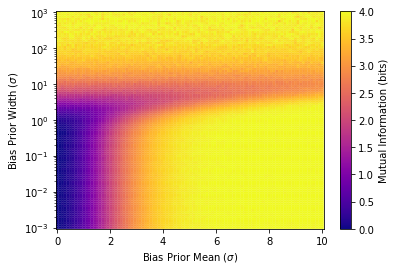

In [16]:
def I2d_plot_wrapper(calc_I=True, save_I=True, num_pow=4, num_draw = int(1e4), save_plot=True,
                     bps = np.logspace(-3, 3, num=100), bpm=np.linspace(0, 10, num=100)):

    prefix = f"mut_info_2d_pow_{num_pow}_draw_{num_draw}"
    npy_fn = f"{prefix}.npy"
    plot_fn = f"{prefix}.pdf"
    if calc_I:
        _, _, I2d = mut_info_wrap("diagonal", num_draw=num_draw, num_pow=num_pow, bias_prior_stds=bps, 
                                      bias_prior_means=bpm)
        if save_I:
            np.save(npy_fn, I2d)
    else:

        I2d = np.load(npy_fn)
    bps_g, bpm_g = np.meshgrid(bps, bpm)
    plt.pcolor(bpm_g, bps_g, I2d.T, cmap='plasma', vmin=0, vmax=4, edgecolors='face')
    plt.colorbar(label="Mutual Information (bits)")
    plt.xlabel("Bias Prior Mean ($\sigma$)")
    plt.ylabel("Bias Prior Width ($\sigma$)")
    plt.yscale("log")
    if save_plot:
        plt.savefig(plot_fn)
    return(I2d)
# New run of notebook will need to run calc_I=True below
I2d = I2d_plot_wrapper(calc_I=False)

# Toy Section: Evaluate classification performance on weak, moderate, and strong outliers when using priors that reflect weak/moderate/strong biases. (Fig 3). Play with entropy (Fig 4). Play with loss functions a bit (Fig 5).


In [17]:


def get_loss(mode='MAP', loss_val=2, sim_list=None, bp_prior_mean=0.1, bp_prior_std=0.05,
             jk_mode='diagonal', bias_prior_std=10, bias_prior_mean=0, num_draw=int(1e4), num_pow=4):
    L = np.ones([2**num_pow, 2**num_pow])
    if mode == 'low_fnr':
        L[0, 1:] = loss_val
    elif mode == 'tpr':
        L[1:, 0] = loss_val
    elif mode == 'mut_info':
        for cind1, combo1 in enumerate(powerset(np.arange(4))):
            for cind2, combo2 in enumerate(powerset(np.arange(4))):
                if cind1 > cind2:
                    L[cind1, cind2] = L[cind2, cind1]
                elif cind1 < cind2:
                    hyp_prior = np.zeros(16)
                    hyp_prior[[cind1, cind2]] = 0.5
                    
                    mix_sim, jk = get_mix_sim_jk(sim_list, hyp_prior, bp_prior_mean=bp_prior_mean,
                                                 num_draw=num_draw,
                                                 bp_prior_std=bp_prior_std, mode=jk_mode,
                                                 bias_prior_std=bias_prior_std,
                                                 bias_prior_mean=bias_prior_mean)
    
    
                    mut_info = get_mut_info_from_mix(jk)
                    L[cind1, cind2] = mut_info
    elif mode != "MAP":
        raise ValueError("Valid modes are MAP, low_fnr, exp, and lin")
    L[np.arange(2**num_pow), np.arange(2**num_pow)] = 0
    return(L)

def get_perf_matr(bpms=[1, 3, 5], true_means=[1, 3, 5], mode='MAP', loss_val=2, num_draw=int(1e4),
                  bias_prior_std=1e-4, save=False, fn="perf_matr.npy", num_pow=4):
    
    perf_matr = np.zeros([len(bpms), len(true_means), 2**num_pow, 2**num_pow])
    for bpm_ind, bpm in enumerate(bpms):
        
        for tm_ind, true_mean in enumerate(true_means):
            sims = make_sim_list('diagonal', num_pow=num_pow, bp_prior_mean=0, bp_prior_std=0, std=1,
                                 bias_prior_std=bias_prior_std, bias_prior_mean=true_mean, num_draw=num_draw)
            if mode == 'mut_info':
                sim_list = make_sim_list('diagonal', num_pow=num_pow, bp_prior_mean=0, bp_prior_std=0, std=1,
                                 bias_prior_std=bias_prior_std, bias_prior_mean=bpm, num_draw=num_draw)
            else:
                sim_list = None
            L = get_loss(mode=mode, loss_val=loss_val, sim_list=sim_list, bp_prior_mean=0, bp_prior_std=0,
                         jk_mode='diagonal', bias_prior_std=bias_prior_std, bias_prior_mean=bpm, num_draw=num_draw,
                         num_pow=num_pow)
            
            jk_list = get_jk_list(sims, mode="diagonal", num_pow=num_pow, bp_prior_mean=0, bp_prior_std=0, std=1,
                                  bias_prior_mean=bpm, bias_prior_std=bias_prior_std, num_draw=num_draw)
            
            for jk_ind, jk in enumerate(jk_list):
                #classes = jk.post.argmax(axis=0)
                classes = (L@jk.post).argmin(axis=0)
                perf_matr[bpm_ind, tm_ind, jk_ind] = np.histogram(classes, bins=np.arange(2**num_pow + 1),
                                                                  density=True)[0]
    if save:
        np.save(perf_matr, fn)

    return(perf_matr)



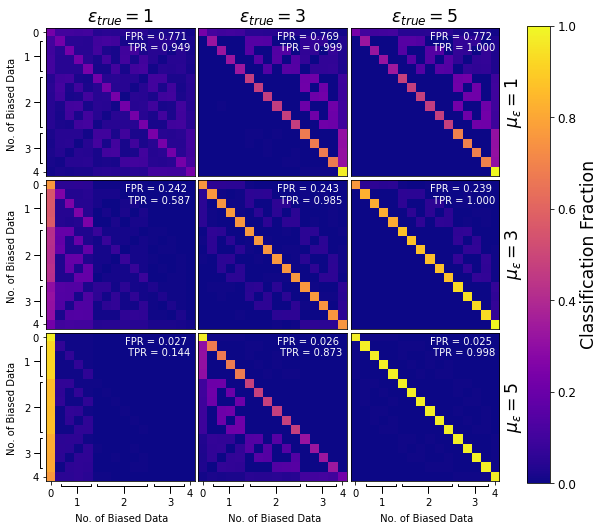

In [18]:


def perf_matr_plot(perf_matr, mode):

    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
    ann_lowy = 16
    ann_lowx = -1
    valid_ax_pairs = [(0,0), (0, 1), (0, 2), (2, 0), (2, 1),(2, 2)]
    for ax_ind1 in range(3):
        for ax_ind2 in range(3):
            imdat = perf_matr[ax_ind1, ax_ind2]
            ax_ob = ax[ax_ind1, ax_ind2]
            cax = ax_ob.imshow(imdat, vmin=0, vmax=1, cmap='plasma')
            stat_dict = {"FPR": 1 - imdat[0, 0], "TPR": 1-  imdat[1:, 0].mean()}
            stat_dict['ratio'] = stat_dict['TPR'] / stat_dict['FPR']
            ax_ob.text(8, 2, "FPR = %.3f \n TPR = %.3f" % (stat_dict['FPR'], stat_dict['TPR']),
                       color='white')
            if ax_ind2 == 0:
                ax_ob.annotate('1', xy=(ann_lowx, 2.5), xytext=(-2.9, 3), arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2',
                                                                                      connectionstyle='angle'),
                              annotation_clip=False)
                ax_ob.annotate('2', xy=(ann_lowx, 7.5), xytext=(-2.9, 8), arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.2',
                                                                                      connectionstyle='angle'),
                              annotation_clip=False)
                ax_ob.annotate('3', xy=(ann_lowx, 12.5), xytext=(-2.9, 13), arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2',
                                                                                      connectionstyle='angle'),
                              annotation_clip=False)
                ax_ob.set_yticks([0, 15])
                ax_ob.set_yticklabels([0, 4])
                ax_ob.set_xticks([])
                ax_ob.set_ylabel("No. of Biased Data \n")

            else:
                ax_ob.set_yticks([])
            if ax_ind1 == 2:
                ax_ob.annotate('1', xy=(2.5, ann_lowy), xytext=(2.5, 18.1),
                               arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2, angleB=-90',
                               connectionstyle='angle'),
                               annotation_clip=False)
                ax_ob.annotate('2', xy=(7.5, ann_lowy), xytext=(7.5, 18.1),
                               arrowprops=dict(arrowstyle='-[, widthB=2.5, lengthB=0.2, angleB=-90',
                               connectionstyle='angle'),
                               annotation_clip=False)
                ax_ob.annotate('3', xy=(12.5, ann_lowy), xytext=(12.5, 18.1),
                               arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2, angleB=-90',
                               connectionstyle='angle'),
                               annotation_clip=False)
                ax_ob.set_xticks([0, 15])
                ax_ob.set_xticklabels([0, 4])
                ax_ob.set_xlabel("\n No. of Biased Data")

                if ax_ind2 > 0:
                    ax_ob.set_yticks([])
            else:
                ax_ob.set_xticks([])
            if ax_ind1 == 0:
                ax_ob.xaxis.set_label_position("top")
            if ax_ind2 == 2:
                ax_ob.yaxis.set_label_position("right")

                
            
            
            

    ax[0, 2].set_ylabel(r"$\mu_\varepsilon = 1$", fontsize="xx-large")
    ax[1, 2].set_ylabel(r"$\mu_\varepsilon = 3$", fontsize="xx-large")
    ax[2, 2].set_ylabel(r"$\mu_\varepsilon = 5$", fontsize="xx-large")
    ax[0, 0].set_title(r"$\varepsilon_{true} = 1$", fontsize="xx-large")
    ax[0, 1].set_title(r"$\varepsilon_{true} = 3$", fontsize="xx-large")
    ax[0, 2].set_title(r"$\varepsilon_{true} = 5$", fontsize="xx-large")
    fig.tight_layout(h_pad=-10.9, w_pad=0.5)
    cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='plasma'), ax=ax,
                        shrink=0.813)
    cbar.set_label("Classification Fraction", fontsize='xx-large')
    cbar.ax.tick_params(labelsize='large')
    fig.savefig(f"toy_class_{mode}.pdf")
    
perf_matr = get_perf_matr(mode='MAP', loss_val=1)
perf_matr_plot(perf_matr, 'MAP')


The cell below is using the "mutual information loss function" which is defined by the Jensen-Shannon divergence b/w any two hypotheses. Bigger divergence == more loss. This is checking a claim MW made in the jackknife paper that this loss function should basically reproduce the MAP rule (above cell).

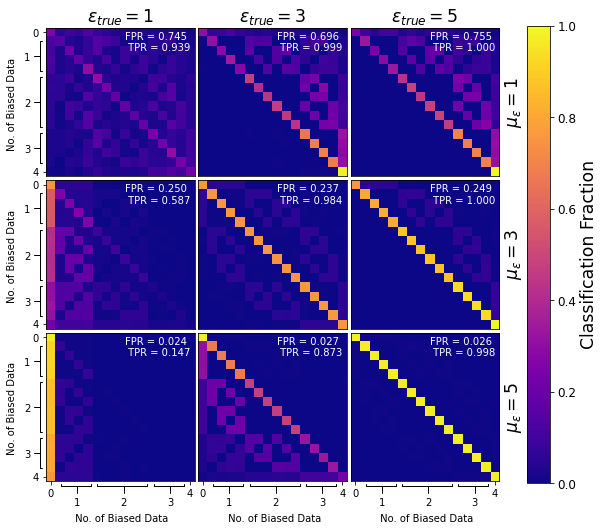

In [19]:
perf_matr = get_perf_matr(mode='mut_info', loss_val=1)
perf_matr_plot(perf_matr, 'mut_info')





# Modulate the loss function and calculate the TPR and FPR as a function of loss level and bias strength, trying to minimize false negatives (Fig. 5)

In [20]:
def get_TPR_FPR(num_loss=10, num_means=10, loss_max=2, mean_max=5, mode="low_fnr", save=True, read=False,
                bias_prior_std=1e-4, bpms=[5, ], num_pow=4):

    
    
    FPR = np.zeros([num_loss, num_means])
    TPR = np.zeros([num_loss, num_means])

    losses=np.logspace(0, loss_max, num=num_loss)
    true_means = np.linspace(0.5, mean_max, num=num_means)
    if read:
        FPR = np.load(f"FPR_{mode}.npy")
        TPR = np.load(f"TPR_{mode}.npy")
    else:
        for loss_ind, loss_val in enumerate(losses):
            perf_matr = get_perf_matr(bpms=bpms, true_means=true_means, mode=mode, num_pow=num_pow,
                                      loss_val=loss_val, bias_prior_std=bias_prior_std)
            for tm_ind in range(num_means):
                FPR[loss_ind, tm_ind] = 1 - perf_matr[0, tm_ind, 0, 0]
                TPR[loss_ind, tm_ind] = 1 - perf_matr[0, tm_ind, 1:, 0].mean()
    if save:
        np.save(f"FPR_{mode}.npy", FPR)
        np.save(f"TPR_{mode}.npy", TPR)
    
    return(losses, true_means, TPR, FPR)

def plot_TPR_FPR(losses, true_means, TPR, FPR, fn):
    start = 0.0
    stop = 1.0
    number_of_lines= 10
    cm_subsection = np.linspace(start, stop, number_of_lines) 

    colors = [ mpl.cm.summer(x) for x in cm_subsection ]
    
    xg, yg = np.meshgrid(losses, true_means, indexing='xy')
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
    FPR = FPR.mean(axis=1)
    for i in range(10):
        color = colors[i]
        ax[0].plot(losses, TPR[:, i], c=color)
        ax[1].plot(losses, FPR, c=colors[-i])
        ax[2].plot(losses, (TPR.T / FPR).T[:, i], c=color)
    #cax0 = ax[0].pcolor(xg, yg, TPR.T, vmin=0, vmax=1, cmap="plasma", edgecolor='face')
    #fig.colorbar(cax0, ax=ax[0], label="TPR")
    
    ax[1].set_ylabel("FPR", fontsize="large")

    #cax2 = ax[2].pcolor(xg, yg, TPR.T / FPR, cmap="plasma", edgecolor='face')
    #fig.colorbar(cax2, ax=ax[2], label="TPR / FPR")
    ax[0].set_ylabel("TPR", fontsize="large")
    ax[2].set_ylabel("TPR / FPR", fontsize="large")
    for ax_ob in ax:
        ax_ob.set_xlabel("False Negative Loss Value", fontsize="large")
        ax_ob.set_xscale("log")
    fig.tight_layout(w_pad=2)
    cbar = fig.colorbar(cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0.5, vmax=5), cmap='summer'), ax=ax)
    cbar.set_label("True Bias Level", fontsize="large")
    plt.savefig(fn)
        


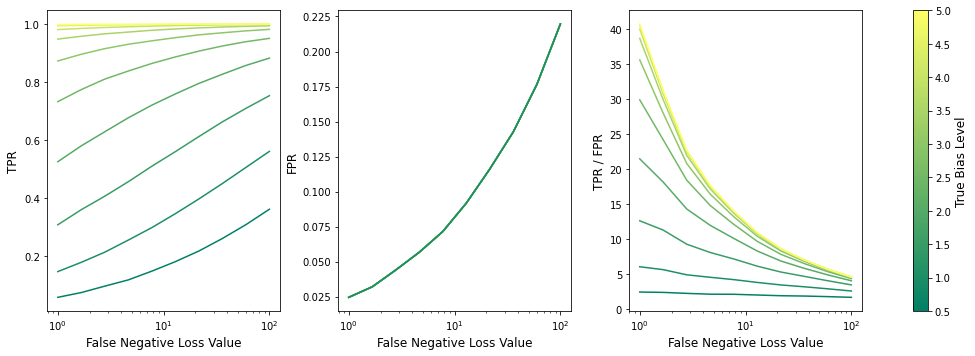

In [21]:
losses, true_means, TPR, FPR = get_TPR_FPR(save=True, read=False)
plot_TPR_FPR(losses, true_means, TPR, FPR, "FPR_TPR_low_fn.pdf")

# Inspect the entropy of the classifications (Fig 4).

In [22]:
def get_spec_H(pms=np.linspace(1, 5, num=20), tms=np.linspace(1,5, num=20), bias_prior_std=1e-4,
               num_draw=int(1e4), calc=False):
    
    if calc:
        H = np.zeros([len(pms), len(tms)])
        for bpm_ind, bpm in enumerate(pms):
            for tm_ind, true_mean in enumerate(tms):
                sims = make_sim_list('diagonal', num_pow=4, bp_prior_mean=0, bp_prior_std=0, std=1,
                                     bias_prior_std=bias_prior_std, bias_prior_mean=true_mean,
                                     num_draw=num_draw)


                jk_list = get_jk_list(sims, mode="diagonal", num_pow=4, bp_prior_mean=0, bp_prior_std=0, std=1,
                                      bias_prior_mean=bpm, bias_prior_std=bias_prior_std, num_draw=num_draw)

                for jk in jk_list:
                    logs = np.where(jk.post > 0, np.log2(jk.post), 0)
                    ent = -np.sum(jk.post * logs, axis=0)
                    H[bpm_ind, tm_ind] += ent.mean() / 16
        np.save('spec_H.npy', H)
    else:
        H = np.load('spec_H.npy')
    return(H)  

pms = np.linspace(0.5, 5, num=20)
tms = np.linspace(0.5, 5, num=20)
# Run calc=True if running notebook for the first time
H = get_spec_H(pms=pms, tms=tms, calc=False)

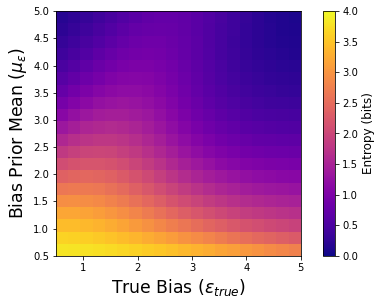

In [23]:

plt.figure(figsize=(8, 4.5))
plt.imshow(H, extent=[0.5, 5, 0.5, 5], origin='lower', vmin=0, vmax=4, cmap='plasma', interpolation='none')
plt.xlabel(r"True Bias ($\varepsilon_{true}$)", fontsize="xx-large")
plt.ylabel(r"Bias Prior Mean ($\mu_{\varepsilon}$)", fontsize="xx-large")
cbar = plt.colorbar()
cbar.set_label("Entropy (bits)", fontsize="large")
plt.savefig("avg_spec_entropy.pdf")

# Do the analysis for the HERA H1C IDR3 Validation Outputs and Bandpowers.

The helper functions in the cells below assume one has access to the bandpowers via the (private) H1C_IDR3_Power_Spectra repository, as well as the public h1c_idr3_validation_outputs repository. One can mock the bandpower outputs using the bandpower data contained in the H1C IDR3 limit paper and the hera_pspec code.

In [24]:

def get_epoch_res_dirs(dat):
    if dat:
        ps_repo = "../../H1C_IDR3_Power_Spectra"
        epoch_0_results = f"{ps_repo}/Epoch_0_Power_Spectra/results_files"
        epoch_res_dirs = [epoch_0_results, ]
        for epoch in range(1, 4):
            epoch_results = f"{ps_repo}/SPOILERS/Epoch_{epoch}_Power_Spectra/results_files"
            epoch_res_dirs.append(epoch_results)
    else:
        ps_repo = "../../h1c_idr3_validation_notebooks/fg_only/pspec_results"
        epoch_res_dirs = [f"{ps_repo}/epoch_{eind}/results_files" for eind in range(4)]
    return(epoch_res_dirs)
    
epoch_res_dirs_test  = get_epoch_res_dirs(True)
print(epoch_res_dirs_test)

epoch_res_dirs_test = get_epoch_res_dirs(False)
print(epoch_res_dirs_test)

['../../H1C_IDR3_Power_Spectra/Epoch_0_Power_Spectra/results_files', '../../H1C_IDR3_Power_Spectra/SPOILERS/Epoch_1_Power_Spectra/results_files', '../../H1C_IDR3_Power_Spectra/SPOILERS/Epoch_2_Power_Spectra/results_files', '../../H1C_IDR3_Power_Spectra/SPOILERS/Epoch_3_Power_Spectra/results_files']
['../../h1c_idr3_validation_notebooks/fg_only/pspec_results/epoch_0/results_files', '../../h1c_idr3_validation_notebooks/fg_only/pspec_results/epoch_1/results_files', '../../h1c_idr3_validation_notebooks/fg_only/pspec_results/epoch_2/results_files', '../../h1c_idr3_validation_notebooks/fg_only/pspec_results/epoch_3/results_files']


In [25]:
def get_epochs_in_band_field(band, field, epoch_res_dirs):
    epoch_list = []
    for epoch, epoch_res_dir in enumerate(epoch_res_dirs):
        if os.path.exists(f"{epoch_res_dir}/Pofk_Band_{band}_Field_{field}.h5"):
            epoch_list.append(epoch)
        elif not os.path.exists(epoch_res_dir):
            raise ValueError("epoch_res_dirs contains directories that do not exist on filesystem. Check "
                             "epoch_res_dirs variable.")
    return(epoch_list)

def get_epoch_dict(epoch_res_dirs, bands='12', fields='ABCDE'):
    epoch_dict = {}
    for band in bands:
        for field in fields:
            band_field_key = (band, field)
            epoch_dict[band_field_key] = get_epochs_in_band_field(band, field, epoch_res_dirs)
    return(epoch_dict)

epoch_dict_test = get_epoch_dict(get_epoch_res_dirs(True))
print(epoch_dict_test)

{('1', 'A'): [0], ('1', 'B'): [0, 1], ('1', 'C'): [0, 1, 2, 3], ('1', 'D'): [0, 1, 2, 3], ('1', 'E'): [1, 2, 3], ('2', 'A'): [0], ('2', 'B'): [0, 1], ('2', 'C'): [0, 1, 2, 3], ('2', 'D'): [0, 1, 2, 3], ('2', 'E'): [1, 2, 3]}


In [26]:
#spw = 0
#field = "B"
#bp_prior_mean = 300
#bp_prior_std = bp_prior_mean / 2
#bias_prior_std = 1e5

def get_uvp_goodies(spw, field, mode, epoch_res_dirs, epoch_dict, epochs=np.arange(4, dtype=int), comp='real'):
    bp_meas = []
    stds = []
    if mode == 'dsq':
        modestr = "Deltasq"
    elif mode == 'pk':
        modestr = 'Pofk'
    else:
        raise ValueError("mode must be 'dsq' or 'pk'")
    for epoch in epochs:
        uvp = UVPSpec()
        path = f"{epoch_res_dirs[epoch]}/{modestr}_Band_{spw}_Field_{field}.h5"
        if os.path.exists(path):
            uvp.read_hdf5(path)
            bp_meas.append(getattr(uvp.data_array[0].squeeze(), comp))
            stds.append(np.sqrt(uvp.cov_array_real[0].squeeze().diagonal()))
        else:
            print(f"Could not find results file for epoch {epoch}, Band {spw}, Field {field}")
            continue

    if spw == 1:
        num_k = 29      
    else:
        num_k = 25
    # First 3 are all 0, only the next num_k are reported in this band
    bp_meas_k = np.array(bp_meas)[:, 3:3 + num_k]
    stds_k = np.array(stds)[:, 3:3 + num_k]
    ks = uvp.get_kparas(0)[3:3 + num_k] # The kparas store the actual k magnitude in these files?
    
    return(bp_meas_k, stds_k, ks)



In [27]:
def get_odds_list_k(ks, stds_k, bp_meas_k, epochs, bppm=10, use_I=False, bias_prior_std=1, jk_mode="diag_only",
                    bias_prior_mean=6, mult=True):
    odds_list_k = []
    conc_list_k = []
    for k_ind, k in enumerate(ks):
        bppm_use = bppm * 2 * np.pi**2 / k**3
        std = stds_k[:, k_ind]
        bp_meas = bp_meas_k[:, k_ind]
        if use_I:
            bias_prior_stds = np.logspace(4, 10, num=100)
            _, I = mut_info_wrap('diagonal', num_pow=len(epochs), bp_prior_mean=bppm_use, bp_prior_std=bppm_use/2,
                                 std=std, bias_prior_stds=bias_prior_stds, num_draw=int(1e4))
            bias_prior_std_use = bias_prior_stds[np.argmax(I / I.max() > 0.9)] 
            print(bias_prior_std / np.amax(std))
        elif mult:
            bias_prior_std_use = bias_prior_std * std
            bias_prior_mean_use = bias_prior_mean * std
        else:
            bias_prior_std_use = bias_prior_std
            bias_prior_mean_use = bias_prior_mean
        odds_list, concs = run_jk(bp_meas, bp_prior_mean=bppm, bp_prior_std = bppm / 2,
                                  bias_prior_mean=bias_prior_mean_use,
                                  std=std, bias_prior_std=bias_prior_std_use, num_pow=len(epochs), diag_only=True)
        odds_list_k.append(odds_list)
        conc_list_k.append(concs)
    
    return(odds_list_k, conc_list_k)
    
def get_epoch_combos(epochs):
    return(np.array(list(powerset(epochs)), dtype=object))
    
def odds_plot_2d(ax, epoch_combos, ks, odds_list_k, band_ind, field_ind, vmin=0.1, vmax=1, log=False,
                 print_stats=False, kfont=20, lw=5):
    num_combo = len(epoch_combos)
    num_k = len(ks)
    image = np.zeros([num_combo, num_k])
    for k_ind in  range(num_k):
        if log:
            image[:, k_ind] = np.log10(odds_list_k[k_ind][0].T)
        else:
            image[:, k_ind] = odds_list_k[k_ind][0].T
    if print_stats:
        avg_comp = np.count_nonzero(image > 0.1, axis=0).mean()
        print(f"Average number of competing hypotheses: {avg_comp}")
    
    ys = np.arange(len(epoch_combos))
    kg, conf_g = np.meshgrid(ks, ys, indexing='xy')
    #cax = ax.imshow(image, aspect='auto', interpolation='none', cmap='plasma', vmax=vmax, vmin=vmin,
                    #extent=[ks[0], ks[-1], num_combo - 0.5, -0.5])
    cax = ax.pcolor(kg, conf_g, image, vmin=vmin, vmax=vmax, cmap='plasma', edgecolors='face')
    ax.set_yticks(ys)
    ax.set_yticklabels(epoch_combos, fontsize="xx-large")
    ax.set_xticks(np.arange(0.25, 2.25, 0.25))
    do_multipanel_labels(ax, band_ind, field_ind, "Bias Configurations", fontsize=30, kfont=kfont)
    ax.tick_params(labelsize="xx-large", length=10)
    num_epoch = int(np.log2(num_combo))
    y = -0.5
    for m in range(num_epoch):
        num_com_m = comb(num_epoch, m)
        y += num_com_m
        ax.axhline(y, color="white", lw=lw)
    
    plt.tight_layout()
    return(cax)
    


def get_stage_inds(stage, odds_list_k):
    
    num_ks = len(odds_list_k)
    bools = [(len(odds_list_k[p]) == stage) for p in range(num_ks)]   
    inds = np.where(bools)
    
    return(inds)

def do_multipanel_labels(ax, band_ind, field_ind, label, fontsize=10, kfont="xx-large"):
    fields = 'BCDE'
    if field_ind == 0:
        if band_ind == 0:
            ax.set_ylabel(f"Band 1 \n {label}", fontsize=fontsize)
        else:
            ax.set_ylabel(f"Band 2 \n {label}", fontsize=fontsize)
    if band_ind == 1:
        ax.set_xlabel("$k$ ($h$ Mpc$^{-1}$)", fontsize=kfont)
    if band_ind == 0:
        ax.set_title(f"Field {fields[field_ind]}", fontsize=kfont)

def do_error_plot(bp_ax, dat, ks, stds, fade_alpha, label, color, odds_list_k, conc_list_k, epoch,
                         epoch_combos, band_ind, field_ind, stagger=0, plot_z=True,
                         fontsize=10):

        outlying_bools = [epoch in epoch_combos[conc_list_k[p][0]["max_post_ind"]] for p in range(len(ks))]
        alphas = [1, 0.15]
        for inds_ind, inds_use in enumerate([np.array(outlying_bools), np.logical_not(outlying_bools)]):
            k_use = np.array(ks)[inds_use]
            dat_use = dat[inds_use]
            std_use = stds[inds_use]
            if not inds_ind:
                label_use = label
            else:
                label_use=None
            if plot_z:
                bp_ax.scatter((k_use + stagger), dat_use / std_use, alpha=alphas[inds_ind],
                            color=color, s=100,
                            marker='.', label=label_use)
            else:
                bp_ax.errorbar((k_use + stagger), dat_use, alpha=alphas[inds_ind],
                                yerr=std_use, color=color,
                                marker='.', linestyle='', markersize=8, label=label_use)
        if plot_z:
            bp_label = "$z$-score"
        else:
            bp_label = "Bandpower \n (mK$^2$ $h^3$ Mpc$^{-3}$)"
        do_multipanel_labels(bp_ax, band_ind, field_ind, bp_label, fontsize=fontsize, kfont=fontsize)
    
def bp_plot(bp_ax, bp_meas_k, stds_k, ks, odds_list_k, epochs, conc_list_k, epoch_combos, band_ind, field_ind,
            stagger=0.004, bppm=10, plot_z=True, fontsize=10, dat=True,
            fade_alpha=0.2):
    

    mu0 = 2 * np.pi**2 * bppm / np.array(ks)**3
    
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    for eind, epoch in enumerate(epochs):
        stagger = 0.004 * eind
        if epoch == 3 and field_ind == 1: # Visual clarity issue
            continue
        else:
            do_error_plot(bp_ax, bp_meas_k[eind], ks, stds_k[eind], fade_alpha, f"epoch {epoch}",
                          colors[epoch], odds_list_k, conc_list_k, epoch, epoch_combos, band_ind, 
                          field_ind, stagger=stagger, fontsize=fontsize,
                          plot_z=plot_z)
    
    
    if dat:
        if band_ind == 0:
            ylim = [-1.5e7, 7.4e7]
            yticks = np.arange(-1, 8) * 1e7
            power = 7
            yticklabels = ['$%.0f \cdot 10^%i$' % (tick / 10**power, power) for tick in yticks]
            for ind in [4, 6, 7]:
                yticklabels[ind] = ''
            bp_ax.set_xticklabels([])
            bp_ax.tick_params(direction='in', axis='x')
            bp_ax.set_yscale("symlog", linthresh=2e7)
        else:
            ylim = [-2.8e6, 5.2e6]
            yticks = np.arange(-2, 6) * 1e6
            power = 6
            yticklabels = ['$%.0f \cdot 10^%i$' % (tick / 10**power, power) for tick in yticks]

            #bp_ax.set_yscale("symlog", linthresh=3.5e6)
        bp_ax.tick_params(labelsize="large", length=10, axis='x')

        bp_ax.set_yticks(yticks)
        bp_ax.set_yticklabels(yticklabels)

        bp_ax.set_ylim(ylim)


        if field_ind > 0:
            bp_ax.tick_params(direction='in', axis='y')
            bp_ax.set_yticklabels([])
        else:
            bp_ax.yaxis.offsetText.set_visible(False)
    else:
        bp_ax.tick_params(labelsize="xx-large", length=10, axis='x')
        bp_ax.set_xticks(np.arange(0.25, 2.25, 0.25))
    
    bp_ax.axhline(0, color='black', linestyle='--')
    bp_ax.set_xlim([0.15, 2.08])
    bp_ax.tick_params(labelsize="xx-large", length=10, axis='y')
    
    
def H_plot(ax, odds_list_k, ks, color=None, markersize=None,
           marker=None, lw=None, markeredgewidth=None, label=None):
    Hs = []
    for k_ind in range(len(ks)):
        odds = odds_list_k[k_ind][0][:, 0]
        p = 1 / (odds * np.sum(1 / odds))
        H = -p @ np.log2(p) 
        Hs.append(H)
    ax.plot(ks, Hs, color=color, markersize=markersize, marker=marker, lw=lw, markeredgewidth=markeredgewidth,
            label=label)
    ax.set_ylim([0, np.log2(len(p))])
    

def do_marg(post_list_k, epochs):

    num_epoch = len(epochs)
    eind_combos = list(powerset(range(num_epoch)))
    num_k = len(post_list_k)
    marg_prob = np.zeros([num_k, num_epoch])
    for k_ind, post in enumerate(post_list_k):
        for eind in range(num_epoch):
            for combo_ind, eind_combo in enumerate(eind_combos):
                if eind in eind_combo:
                    marg_prob[k_ind, eind] += post[0][combo_ind]
    return(marg_prob)

def odds_plot(ax, ks, post_list_k, band_ind, field_ind, print_stats=False, color=None, label=None, marker=None,
              arrow=False, ahigh=1e6, alow=1e-6, line=False, markersize=20, alpha=0.5, lw=1.8, dashz=-200,
              markeredgewidth=2, dash=True, write=False):
    
    
    new_odds_arr = np.array([])
    for k_ind, k in enumerate(ks):
        new_odds =  post_list_k[k_ind][0][1:].sum() / post_list_k[k_ind][0][0]
        new_odds_arr = np.append(new_odds_arr, new_odds)
    
    if write:
        field = 'BCDE'[field_ind]
        xy_arr = np.array([ks, new_odds_arr])
        np.save(f"bp_final_plots/jackknife_odds_band_{band_ind + 1}_field_{field}.npy", xy_arr)
    if line:
        ax.plot(ks, new_odds_arr, color=color, label=label, marker=marker, markersize=markersize, alpha=alpha,
                lw=lw, markeredgewidth=markeredgewidth)
    else:
        ax.scatter(ks, new_odds_arr, color=color, label=label, marker=marker, alpha=alpha)
    if arrow:
        pass
    if dash:
        ax.axhline(1, linestyle='--', color='black', zorder=dashz)
        ax.axhline(10, linestyle='--', color='red', zorder=dashz)
    ax.set_yscale("log")
    do_multipanel_labels(ax, band_ind, field_ind, "Odds of at Least One Significant Bias")
    
    if print_stats:
        num_strong = np.count_nonzero(new_odds_arr > 10)
        num_mod = np.count_nonzero(np.logical_and(new_odds_arr > 1, new_odds_arr < 10))
        print(f"Number of modes with strong evidence for bias: {num_strong}")
        print(f"Number of modes with moderate evidence for bias: {num_mod}")

def bias_jackknife_wrapper(comp="real", bppm=10, stagger=0.004, use_I=False, fade_alpha=0.2, outdir='bp_final_plots',
                           bias_prior_std=1, jk_mode="diag_only", fields='BCDE', bias_prior_mean=6,
                           dual_mean=False, plot_z=True, mult=True, close=False, print_stats=False, odds_2d_vmin=0,
                           print_ks=False, fontsize=10, dat=True, kfont=20, add=False,
                           odds_ticksize=20, odds_ticklen=20, bp_ticksize=25, lw=5):
    
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    fig, ax = plt.subplots(figsize=(32, 8), nrows=2, ncols=4)
    conc_fig, conc_ax = plt.subplots(figsize=(32, 16), nrows=2, ncols=4)
    if dat:
        bp_fig, bp_ax = plt.subplots(figsize=(20, 8), nrows=2, ncols=4)
    else:
        bp_fig, bp_ax = plt.subplots(figsize=(32, 16), nrows=2, ncols=4)
    odds_fig, odds_ax = plt.subplots(figsize=(32, 16), nrows=2, ncols=4)
    bands = '12'
    
    epoch_res_dirs = get_epoch_res_dirs(dat)
    epoch_dict = get_epoch_dict(epoch_res_dirs, bands, fields)
    for band_ind, band in enumerate(list('12')):
        for field_ind, field in enumerate(list(fields)):
            epochs = epoch_dict[(band, field)]
            bp_meas_k, stds_k, ks = get_uvp_goodies(int(band), field, 'pk', epoch_res_dirs, epoch_dict,
                                                    epochs=epochs, comp=comp)
            if add:
                bp_meas_k[0] += 1e6
            if print_ks and field_ind ==0:
                print(ks)
            odds_list_k, conc_list_k = get_odds_list_k(ks, stds_k, bp_meas_k, epochs, bppm=bppm, use_I=use_I,
                                                       bias_prior_std=bias_prior_std, jk_mode=jk_mode,
                                                       bias_prior_mean=bias_prior_mean, mult=mult)

            post_list_k = [odds / np.sum(odds) for odds in odds_list_k]

            epoch_combos = get_epoch_combos(epochs)
            H_plot(ax[band_ind, field_ind], odds_list_k, ks)
            cax = odds_plot_2d(conc_ax[band_ind, field_ind], epoch_combos, ks, odds_list_k, band_ind,
                               field_ind, print_stats=print_stats, vmin=odds_2d_vmin, kfont=kfont, lw=lw)
            bp_plot(bp_ax[band_ind, field_ind], bp_meas_k, stds_k, ks, odds_list_k, epochs, conc_list_k,
                    epoch_combos, band_ind, field_ind, bppm=bppm, stagger=stagger, fade_alpha=fade_alpha,
                    plot_z=plot_z, fontsize=fontsize, dat=dat)
            odds_plot(odds_ax[band_ind, field_ind], ks, post_list_k, band_ind, field_ind,
                      print_stats=print_stats)
            conc_ax[band_ind, field_ind].xaxis.set_minor_locator(AutoMinorLocator(5))
            conc_ax[band_ind, field_ind].set_xticks(np.arange(0.5, 2.5, 0.5))

            conc_ax[band_ind, field_ind].tick_params(labelsize=odds_ticksize, length=odds_ticklen)
            conc_ax[band_ind, field_ind].tick_params(which='minor', length=odds_ticklen // 2)
            
            bp_ax[band_ind, field_ind].xaxis.set_minor_locator(AutoMinorLocator(5))
            bp_ax[band_ind, field_ind].set_xticks(np.arange(0.5, 2.5, 0.5))
            bp_ax[band_ind, field_ind].tick_params(axis='x', labelsize=bp_ticksize,
                                                   length=odds_ticklen)
            if band_ind == 0:
                direction = 'in'
            else:
                direction = 'out'
                bp_ax[band_ind, field_ind].set_xlabel("$k$ ($h$ Mpc$^{-1}$)", fontsize=kfont)
            bp_ax[band_ind, field_ind].tick_params(axis='x', direction=direction, which='minor',
                                                   length=odds_ticklen // 2)
      
            #bp_fig.legend(fontsize="xx-large", frameon=False)
    if dat:
        bp_fig.tight_layout(h_pad=-0.2, w_pad=-1)
        bp_fig.legend(*bp_ax[1, 2].get_legend_handles_labels(), fontsize="xx-large", loc="upper right")
    
    norm = mpl.colors.Normalize(vmin=odds_2d_vmin, vmax=1)
    conc_fig.tight_layout(h_pad=1, w_pad=4)
    cbar = conc_fig.colorbar(cm.ScalarMappable(norm=norm, cmap='plasma'), ax=conc_ax)
    cbar.set_label("Odds against Maximum a Posteriori Hypothesis", fontsize=40)
    cbar.ax.tick_params(labelsize=odds_ticksize, length=odds_ticklen)
    
    
    tag = f"_{comp}_bps_{bias_prior_std}_bpm_{bias_prior_mean}_mult_{mult}_plot_z_{plot_z}_add_{add}"
    fig.savefig(f"{outdir}/entropy_{tag}.pdf")
    conc_fig.savefig(f"{outdir}/stoplight_{tag}.pdf")
    bp_fig.savefig(f"{outdir}/bandpowers_{tag}.pdf")
    odds_fig.savefig(f"{outdir}/odds_{tag}.pdf")
    if close:
        for figure in [fig, conc_fig, bp_fig, odds_fig]:
            plt.close(figure)
    



Next cell does basic results outputs for the bandpowers.

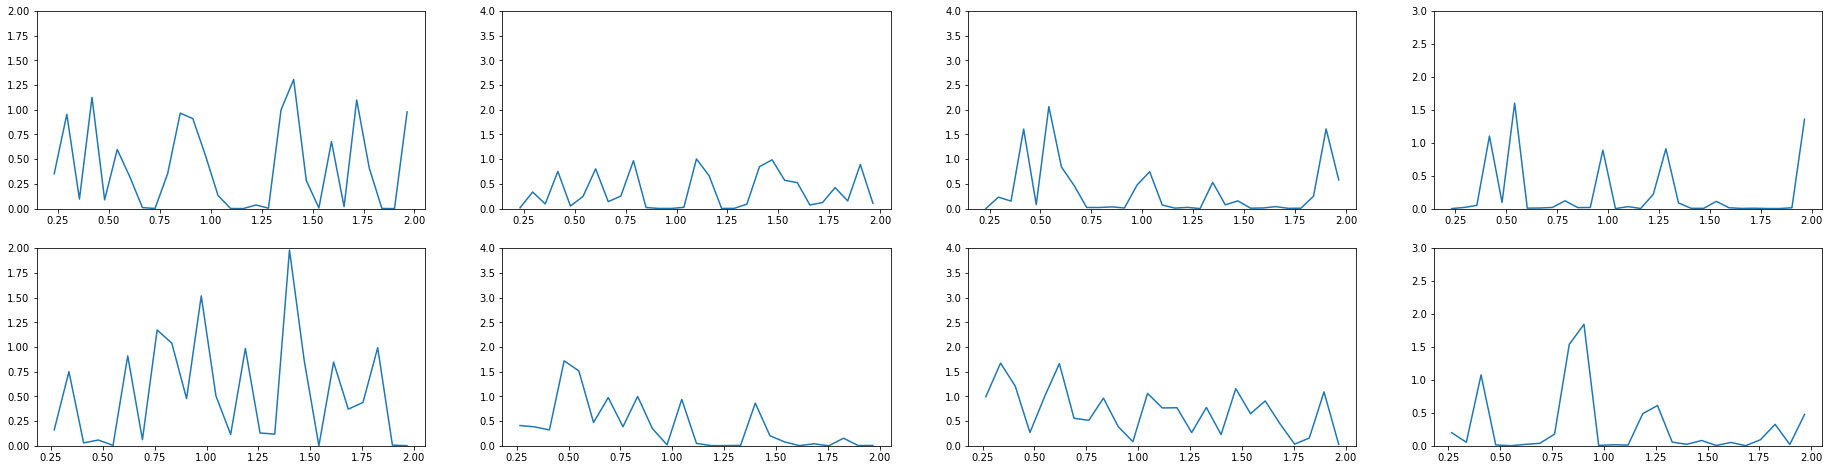

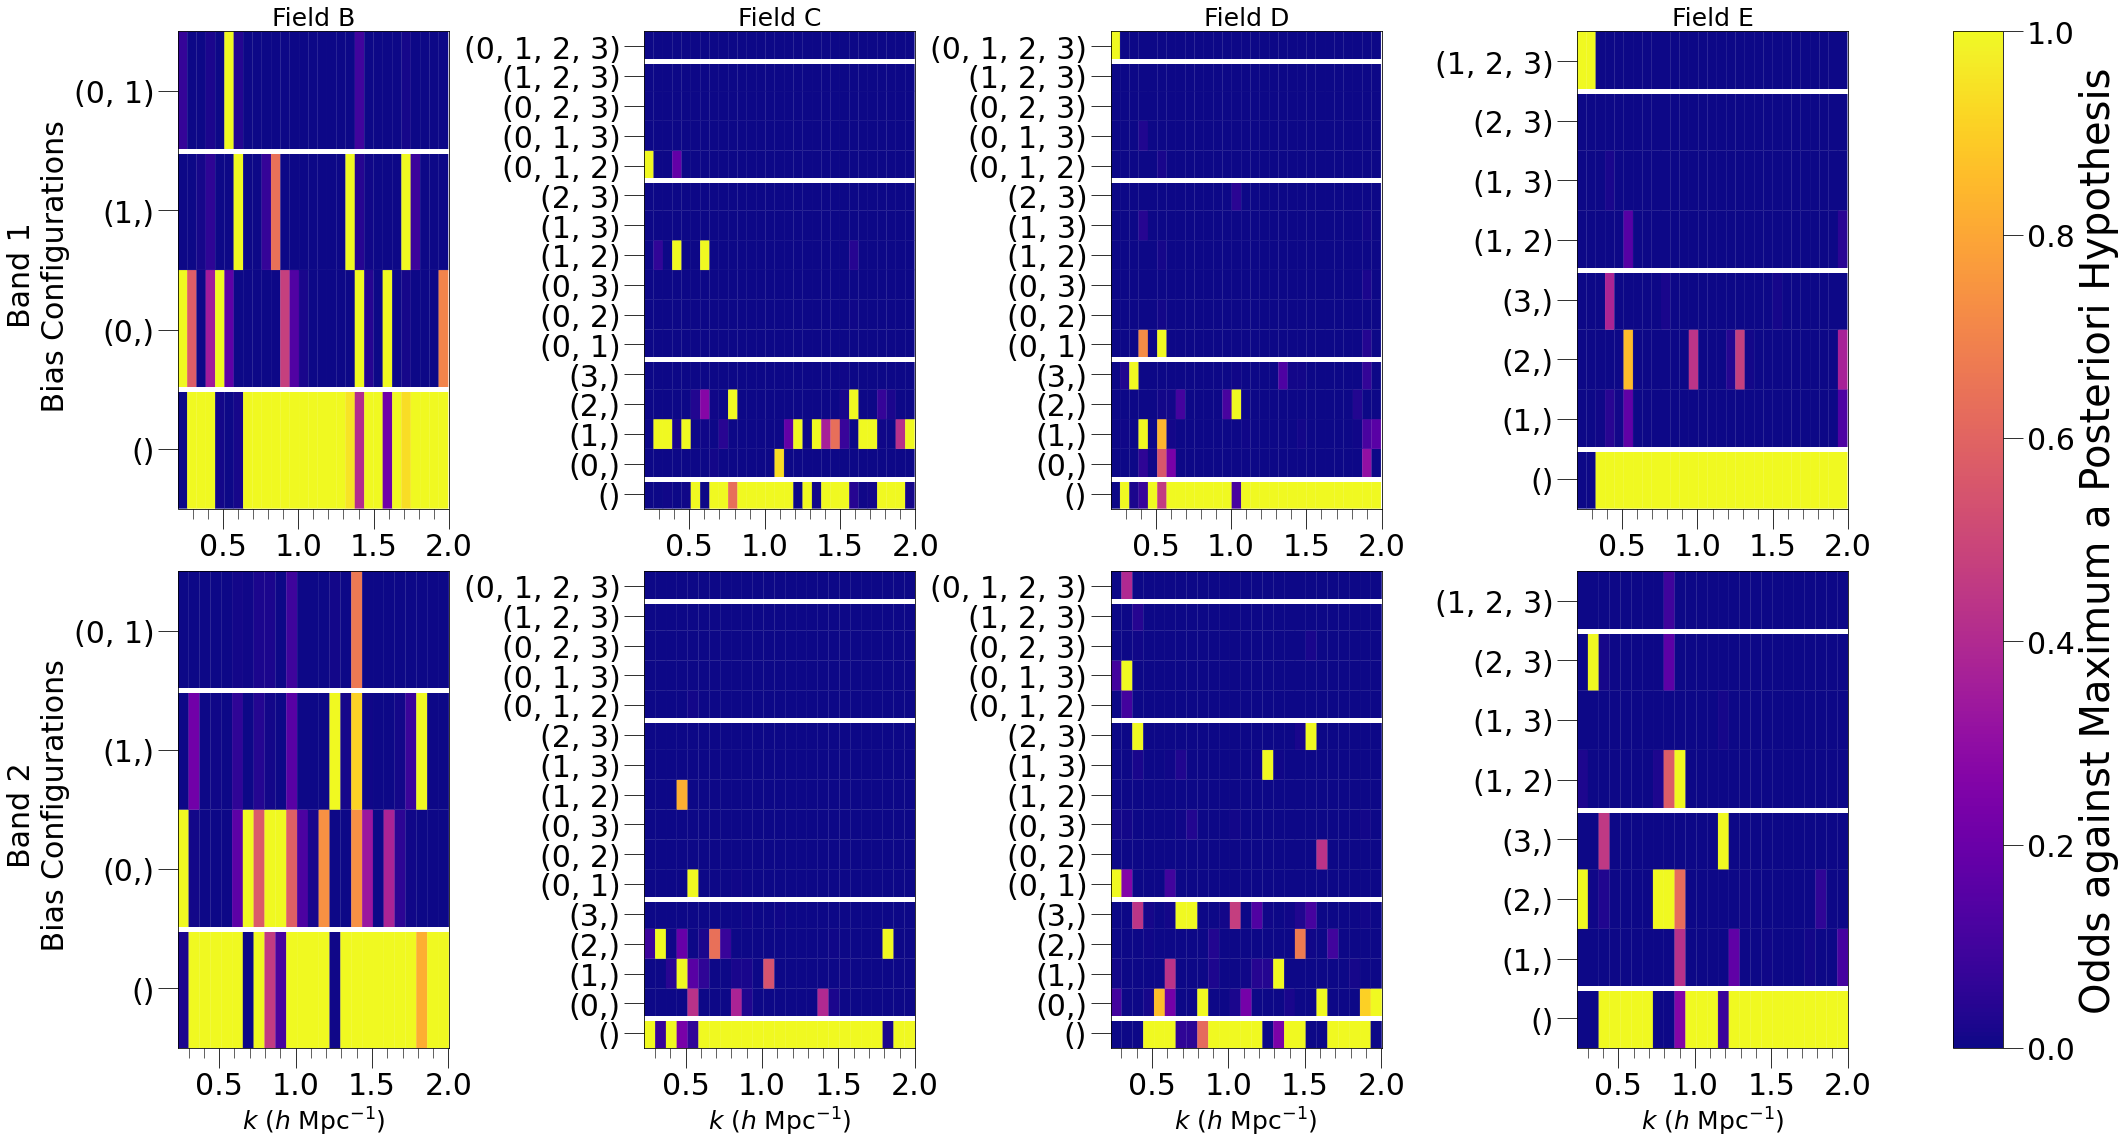

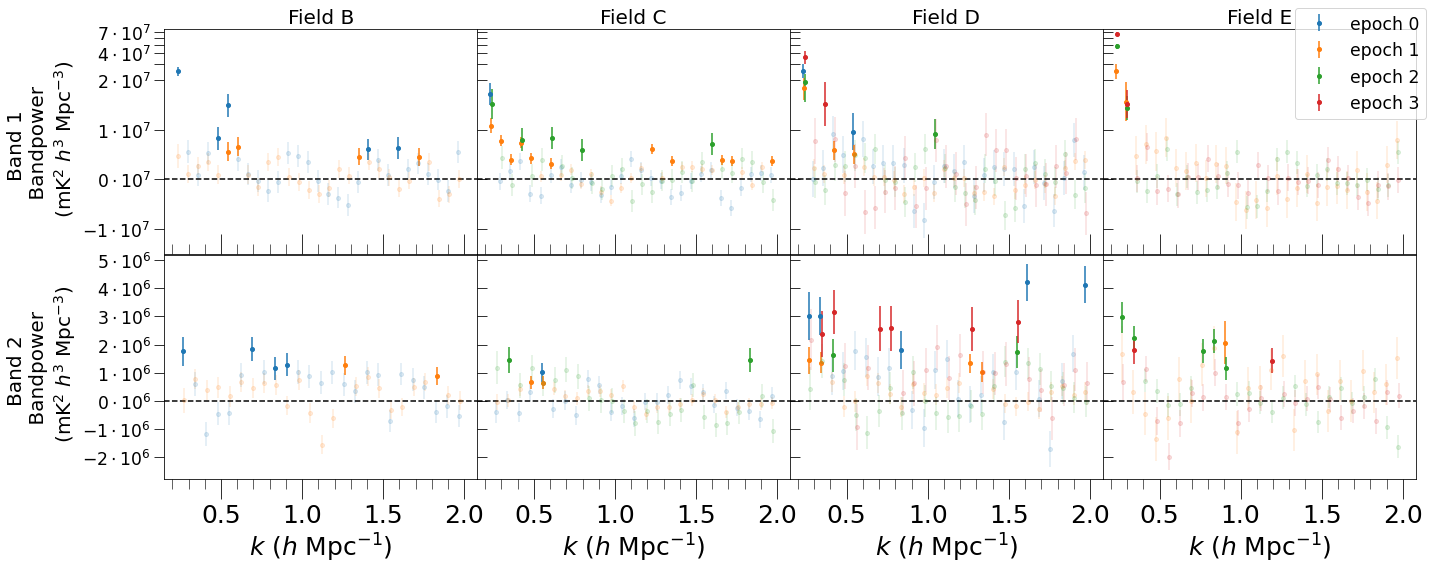

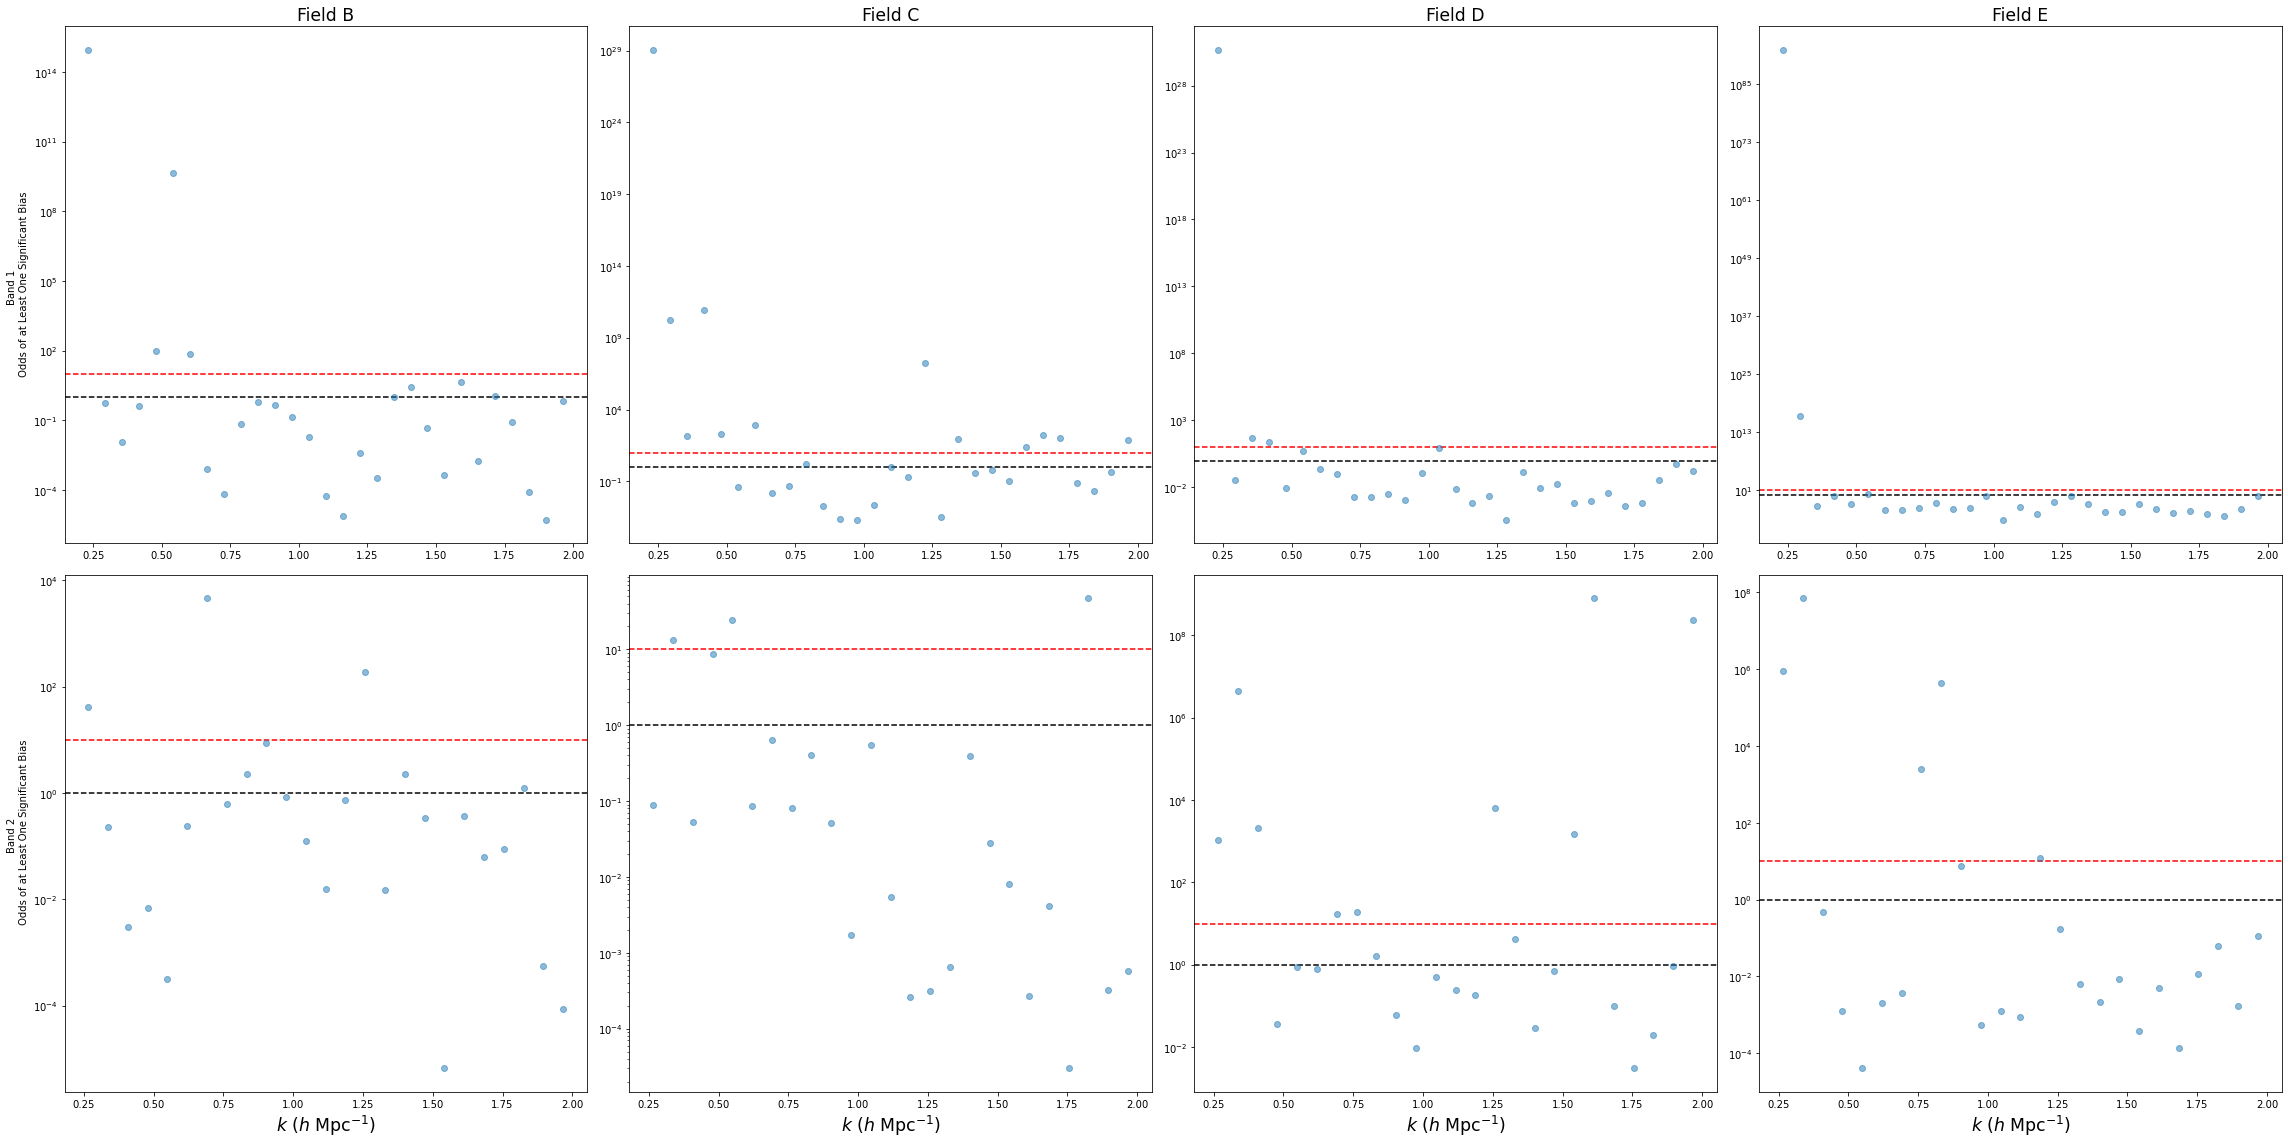

In [28]:
bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1, bppm=0, jk_mode="diag_only",
                       fields='BCDE', bias_prior_mean=6, plot_z=False, print_ks=False, fontsize=20,
                       kfont=25, odds_ticksize=30, odds_ticklen=20)

Next cell does basic results outputs for validation results.

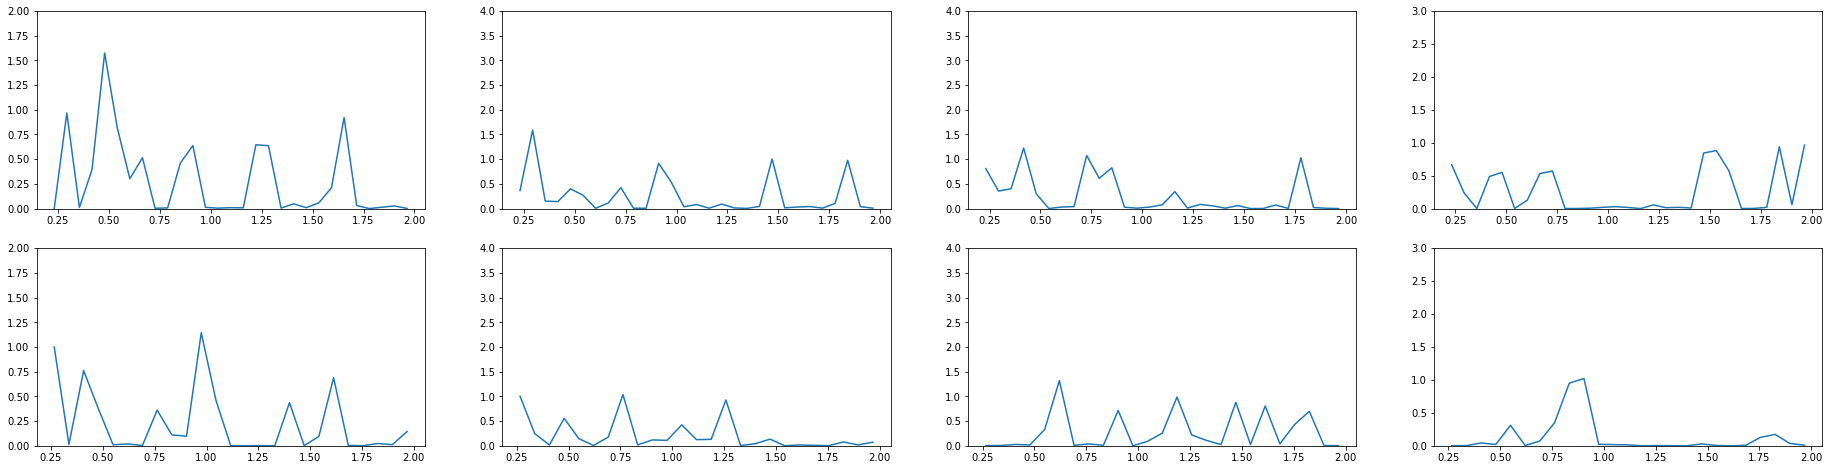

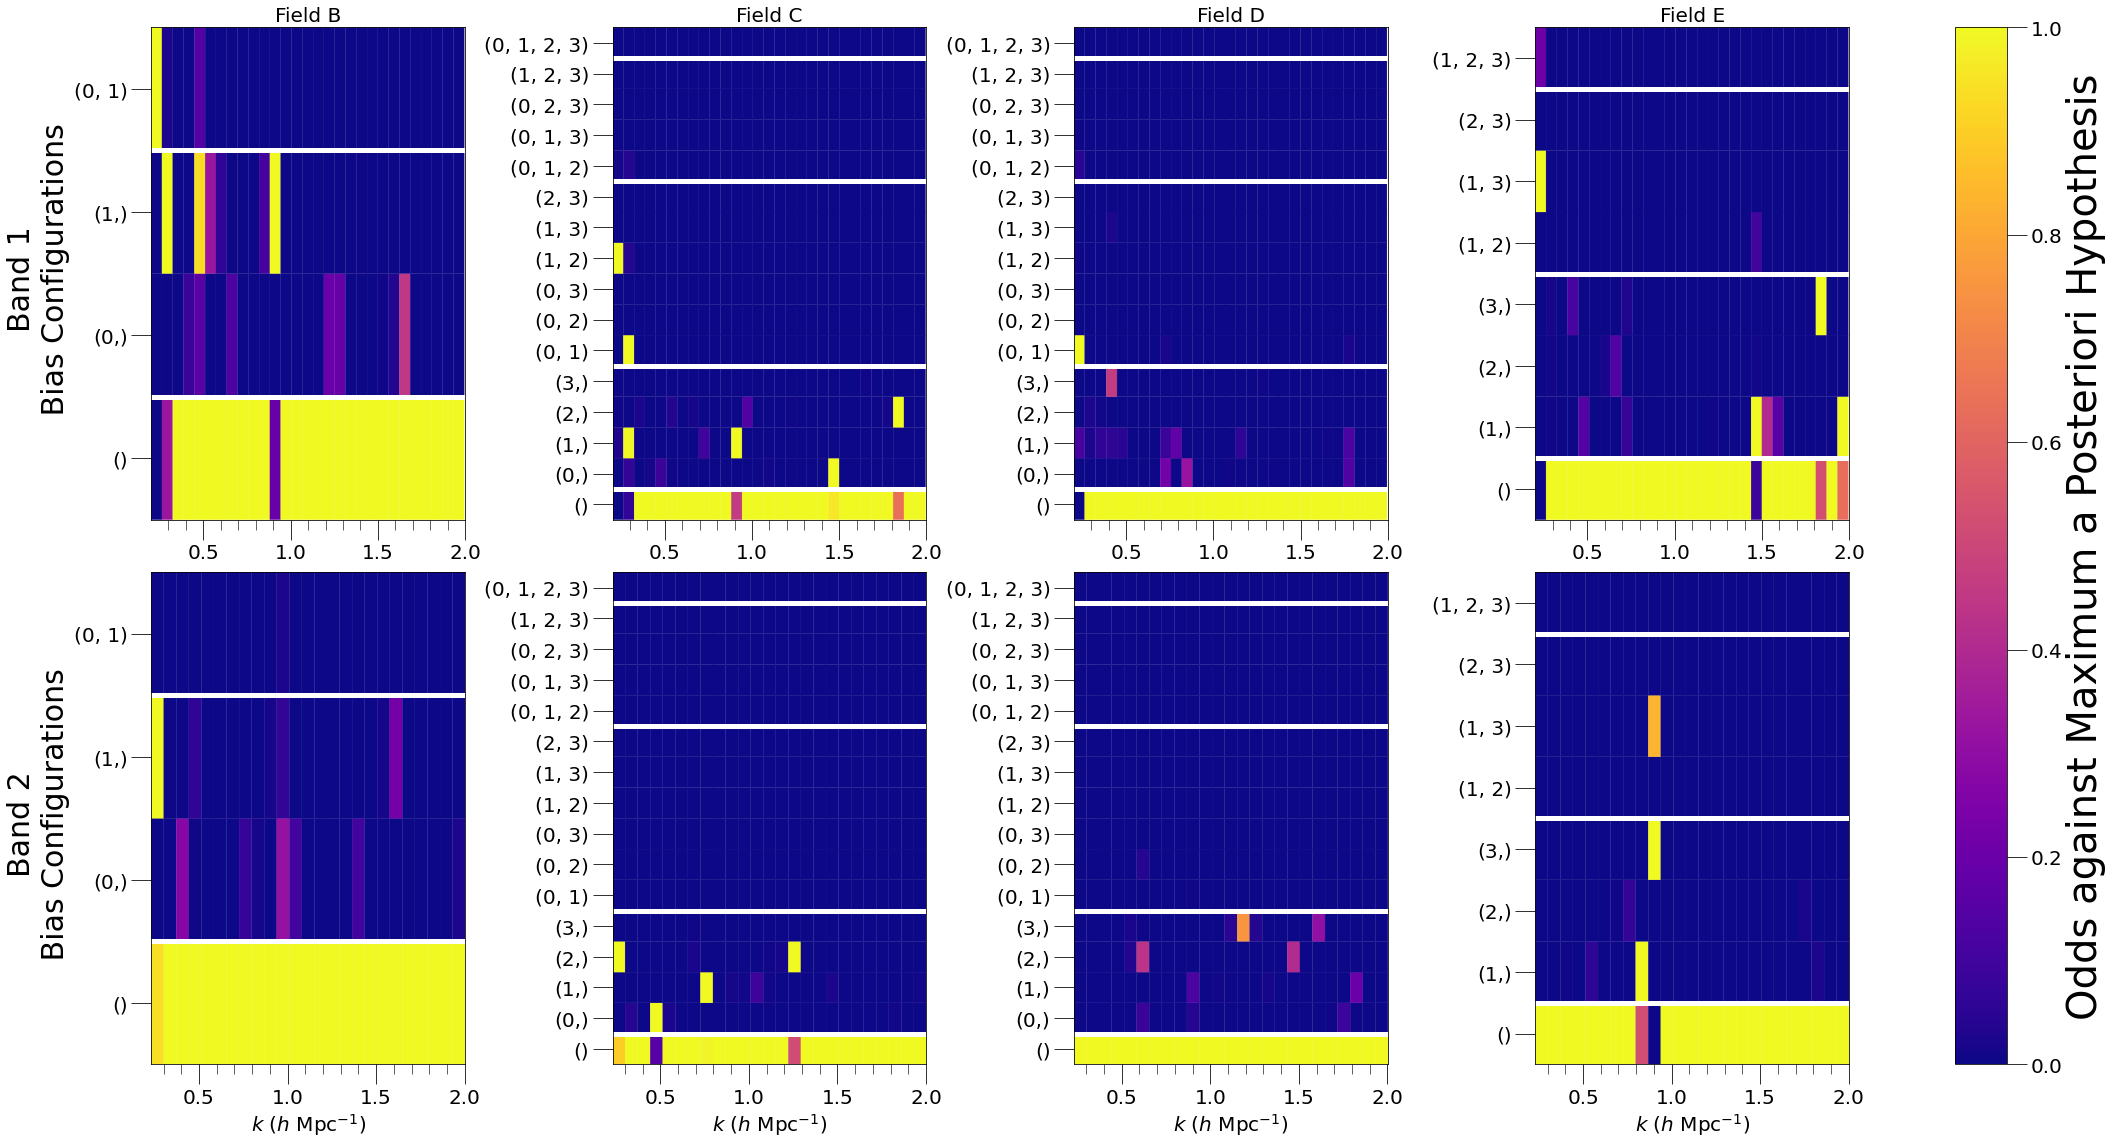

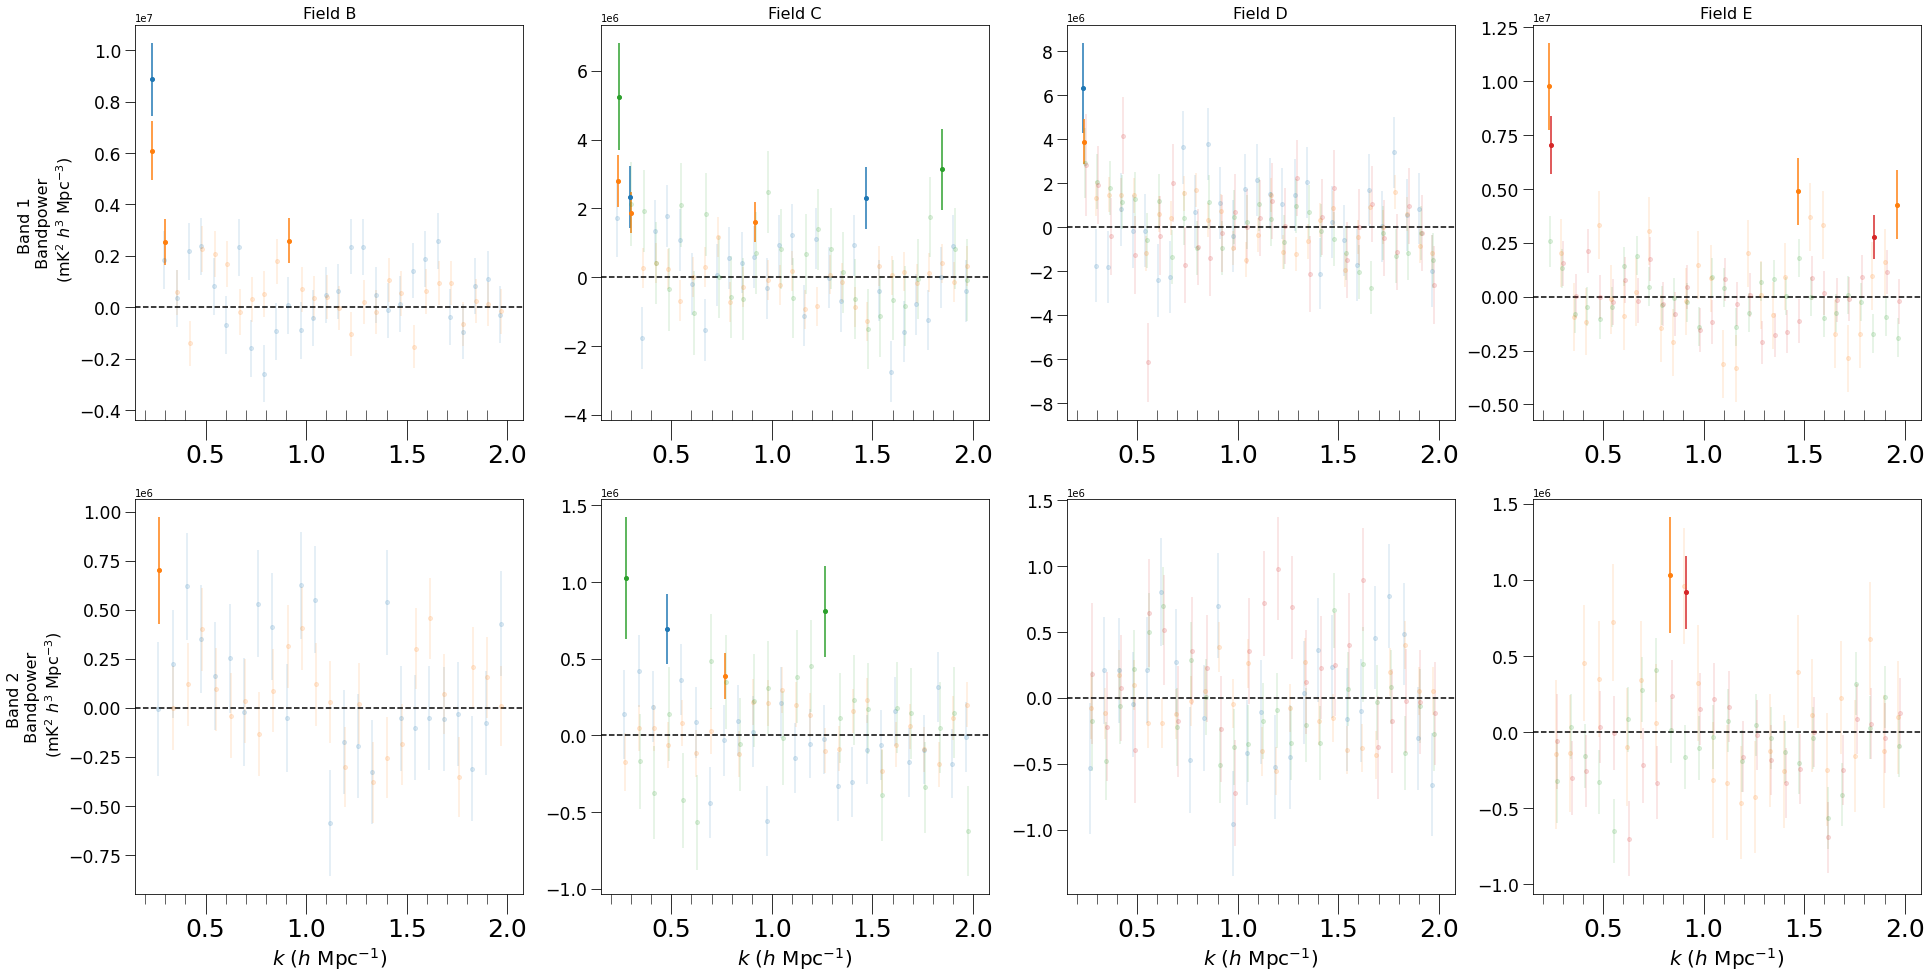

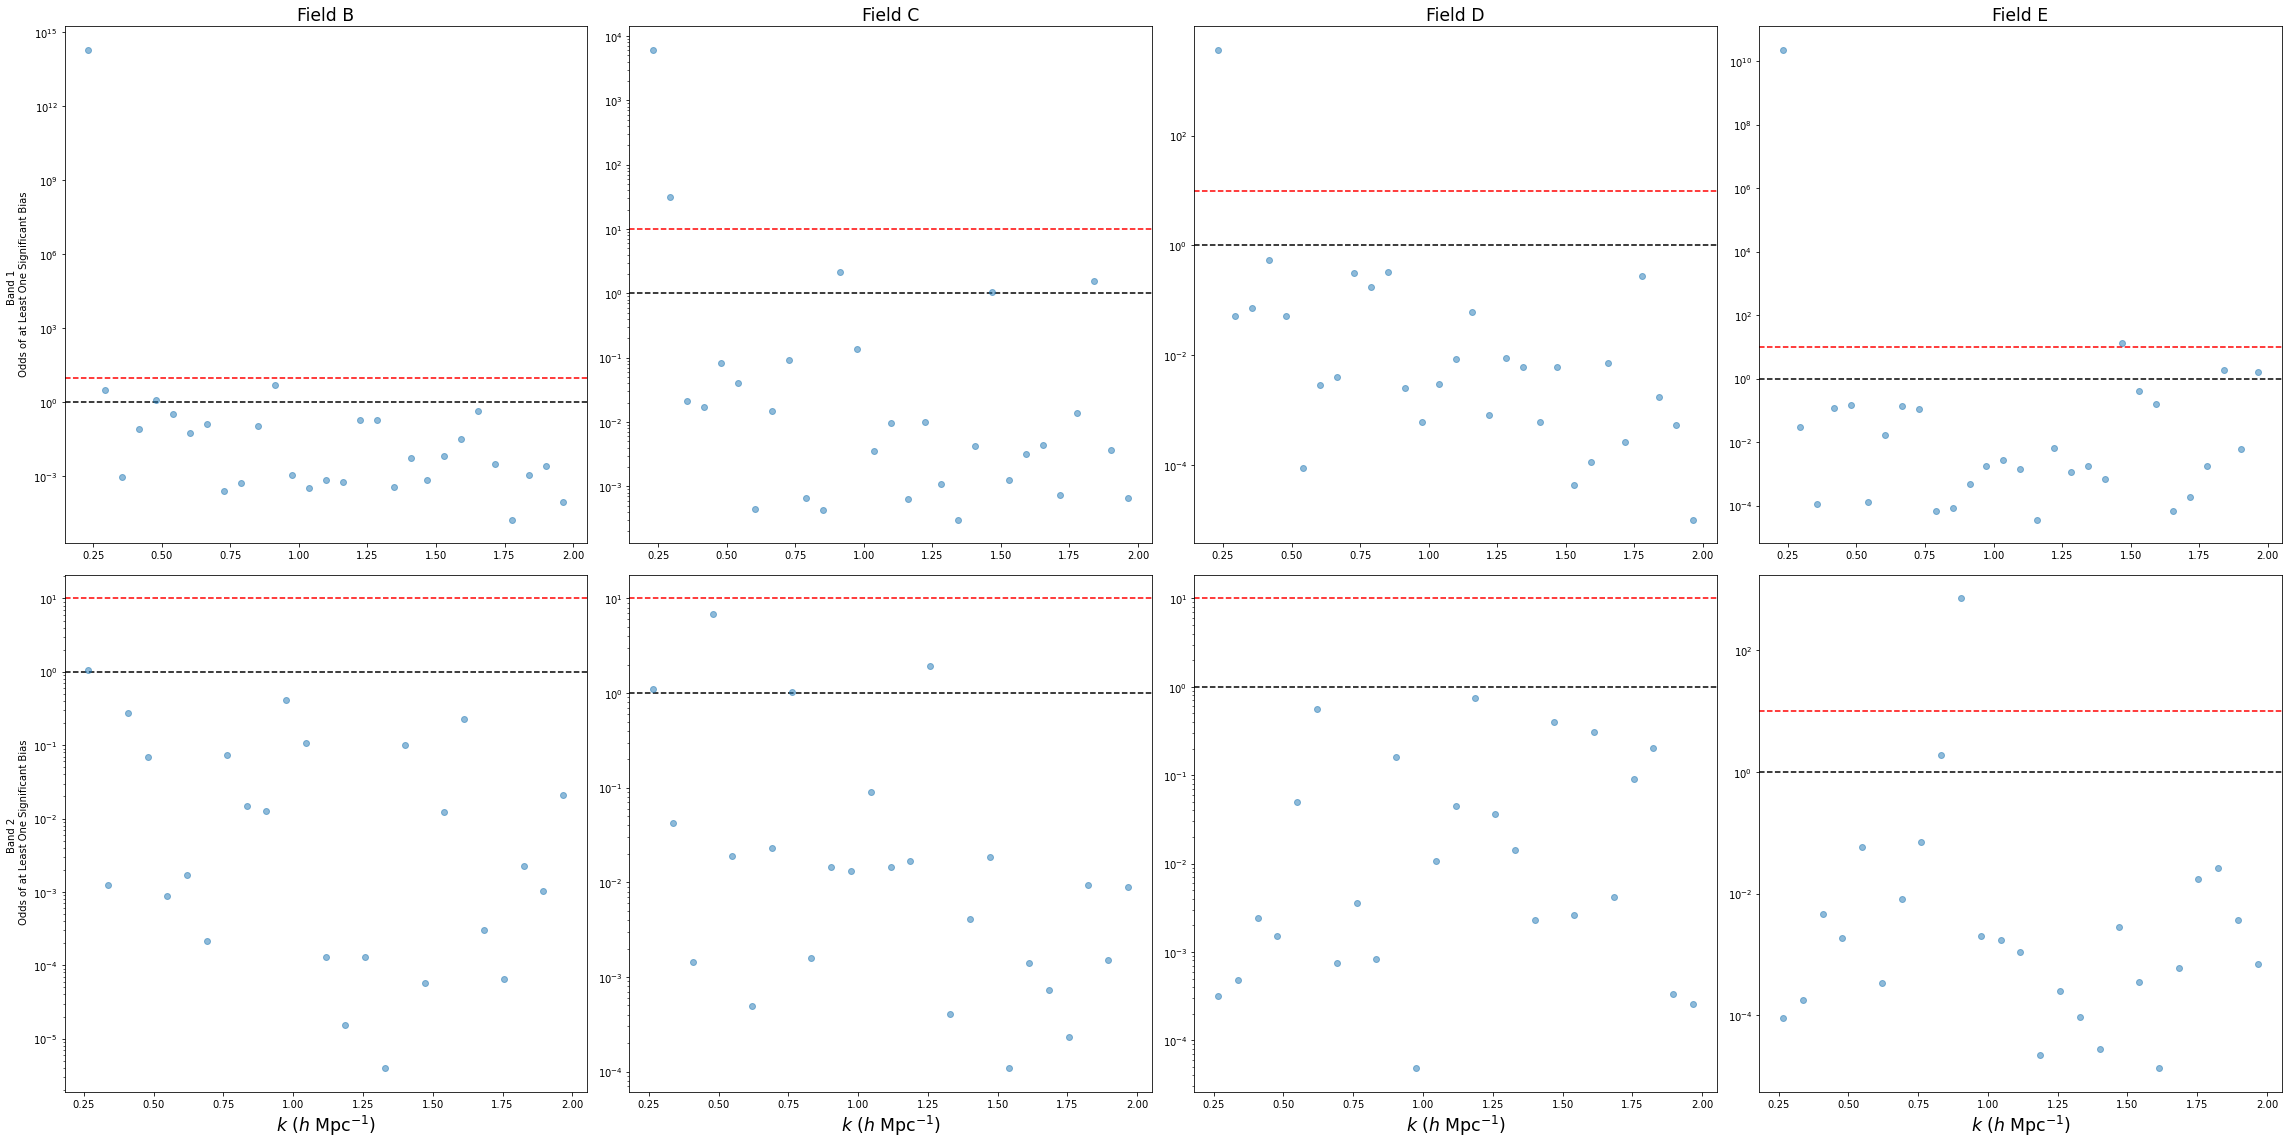

In [29]:
bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1, bppm=0, jk_mode="diag_only",
                       fields='BCDE', bias_prior_mean=6, plot_z=False, outdir="bp_valid_final_plots",
                       fontsize=16, add=False, dat=False)

Look for positive biases in the imaginary component.

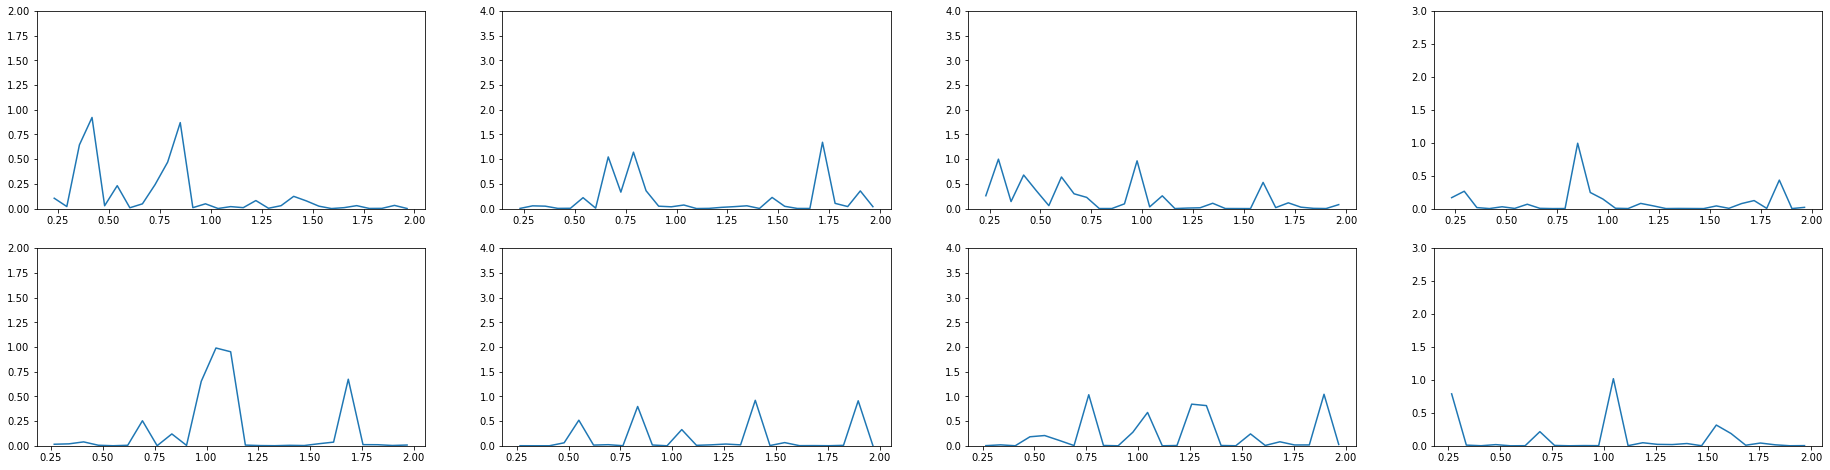

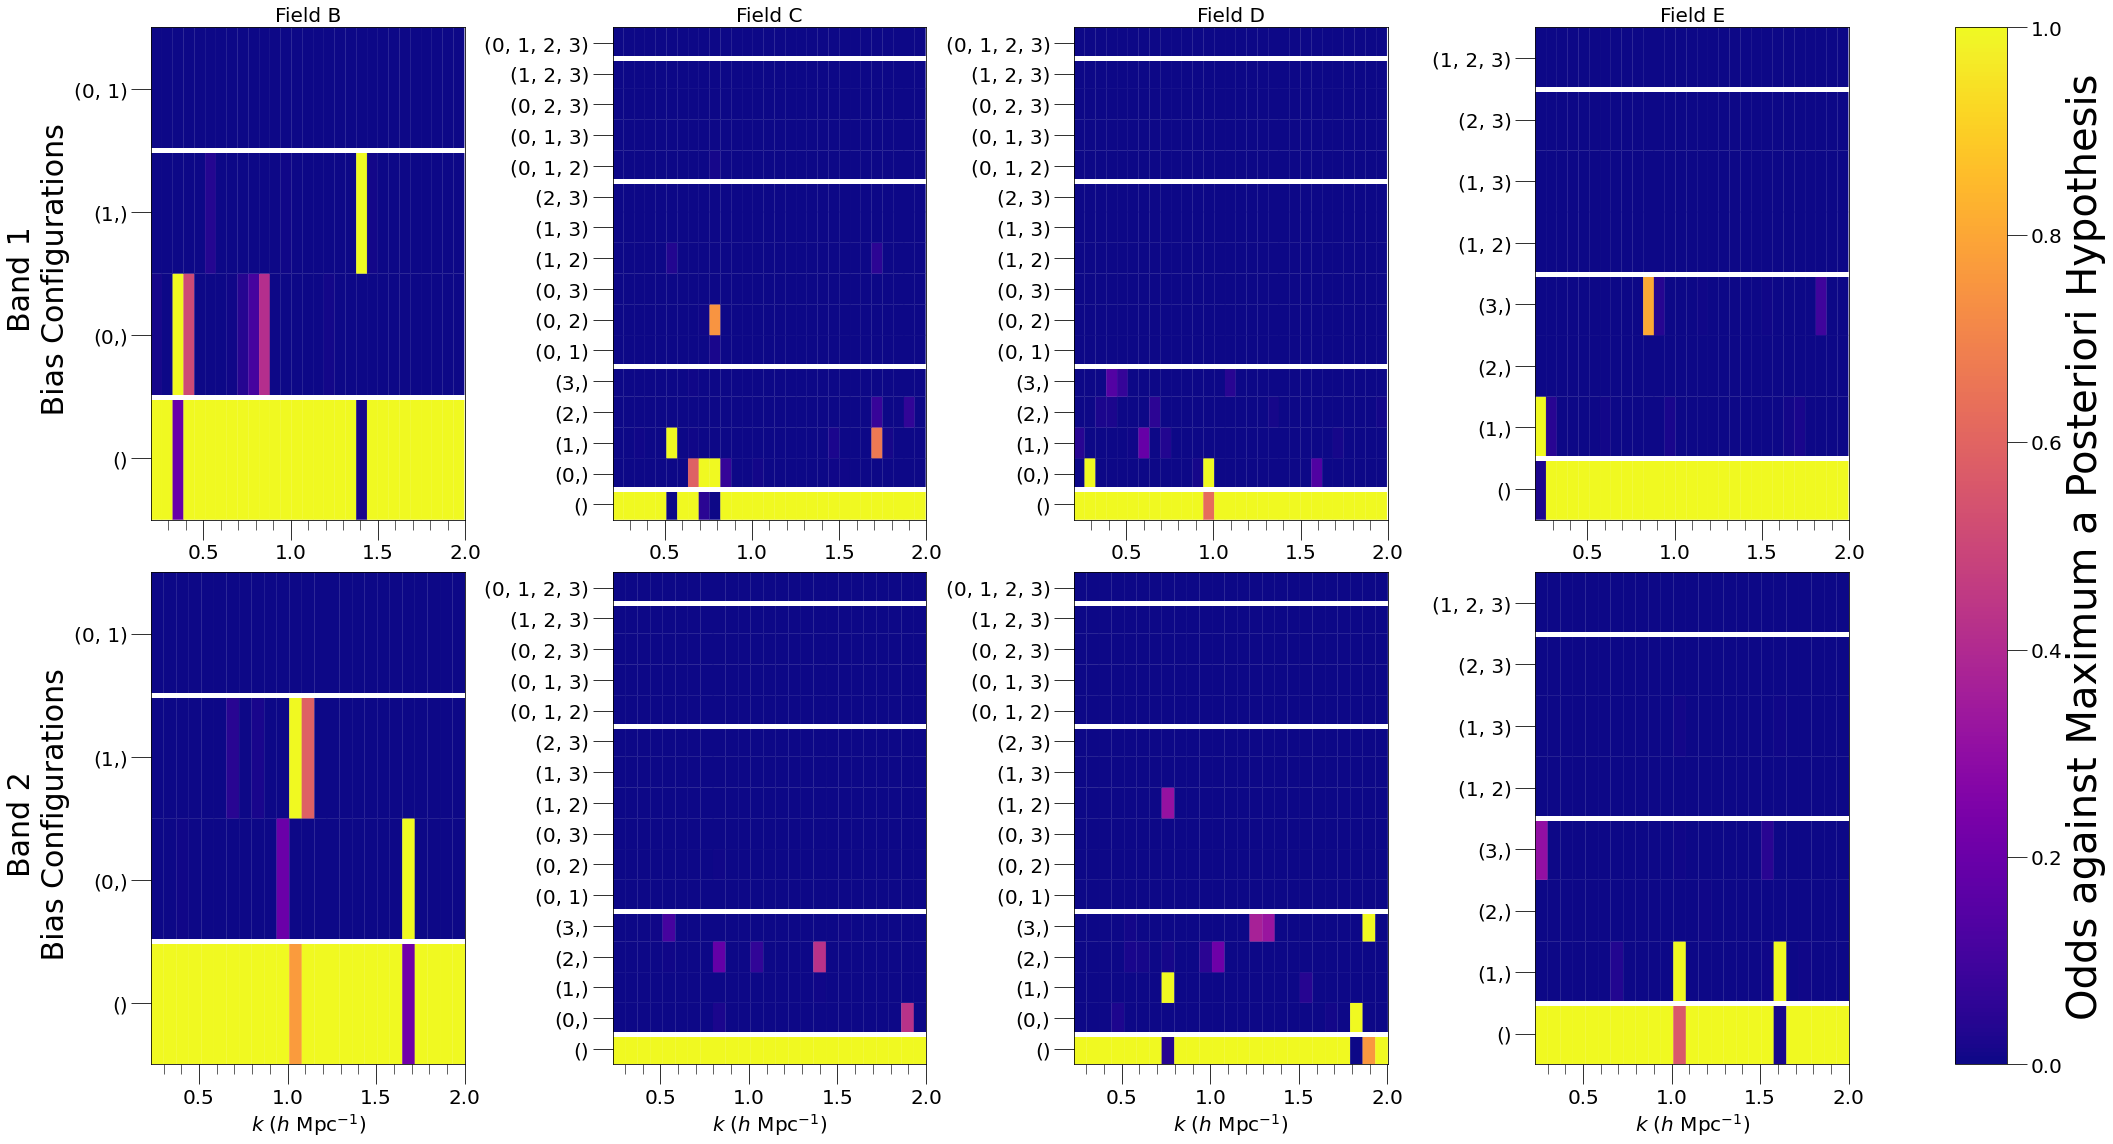

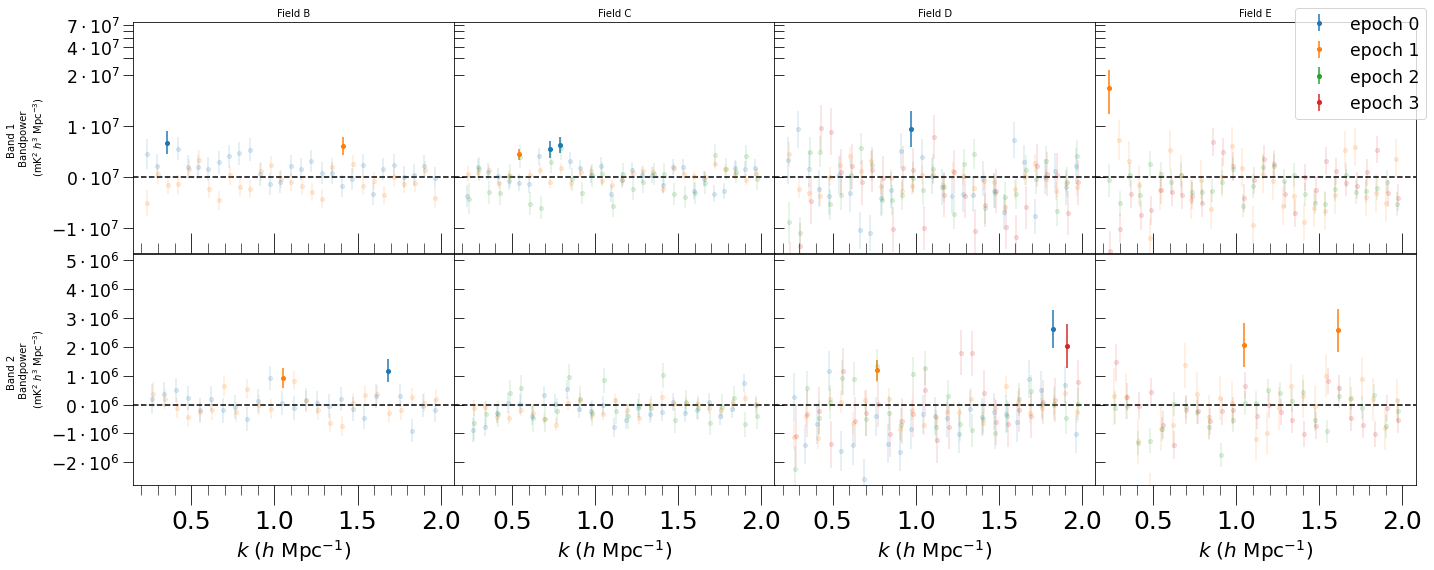

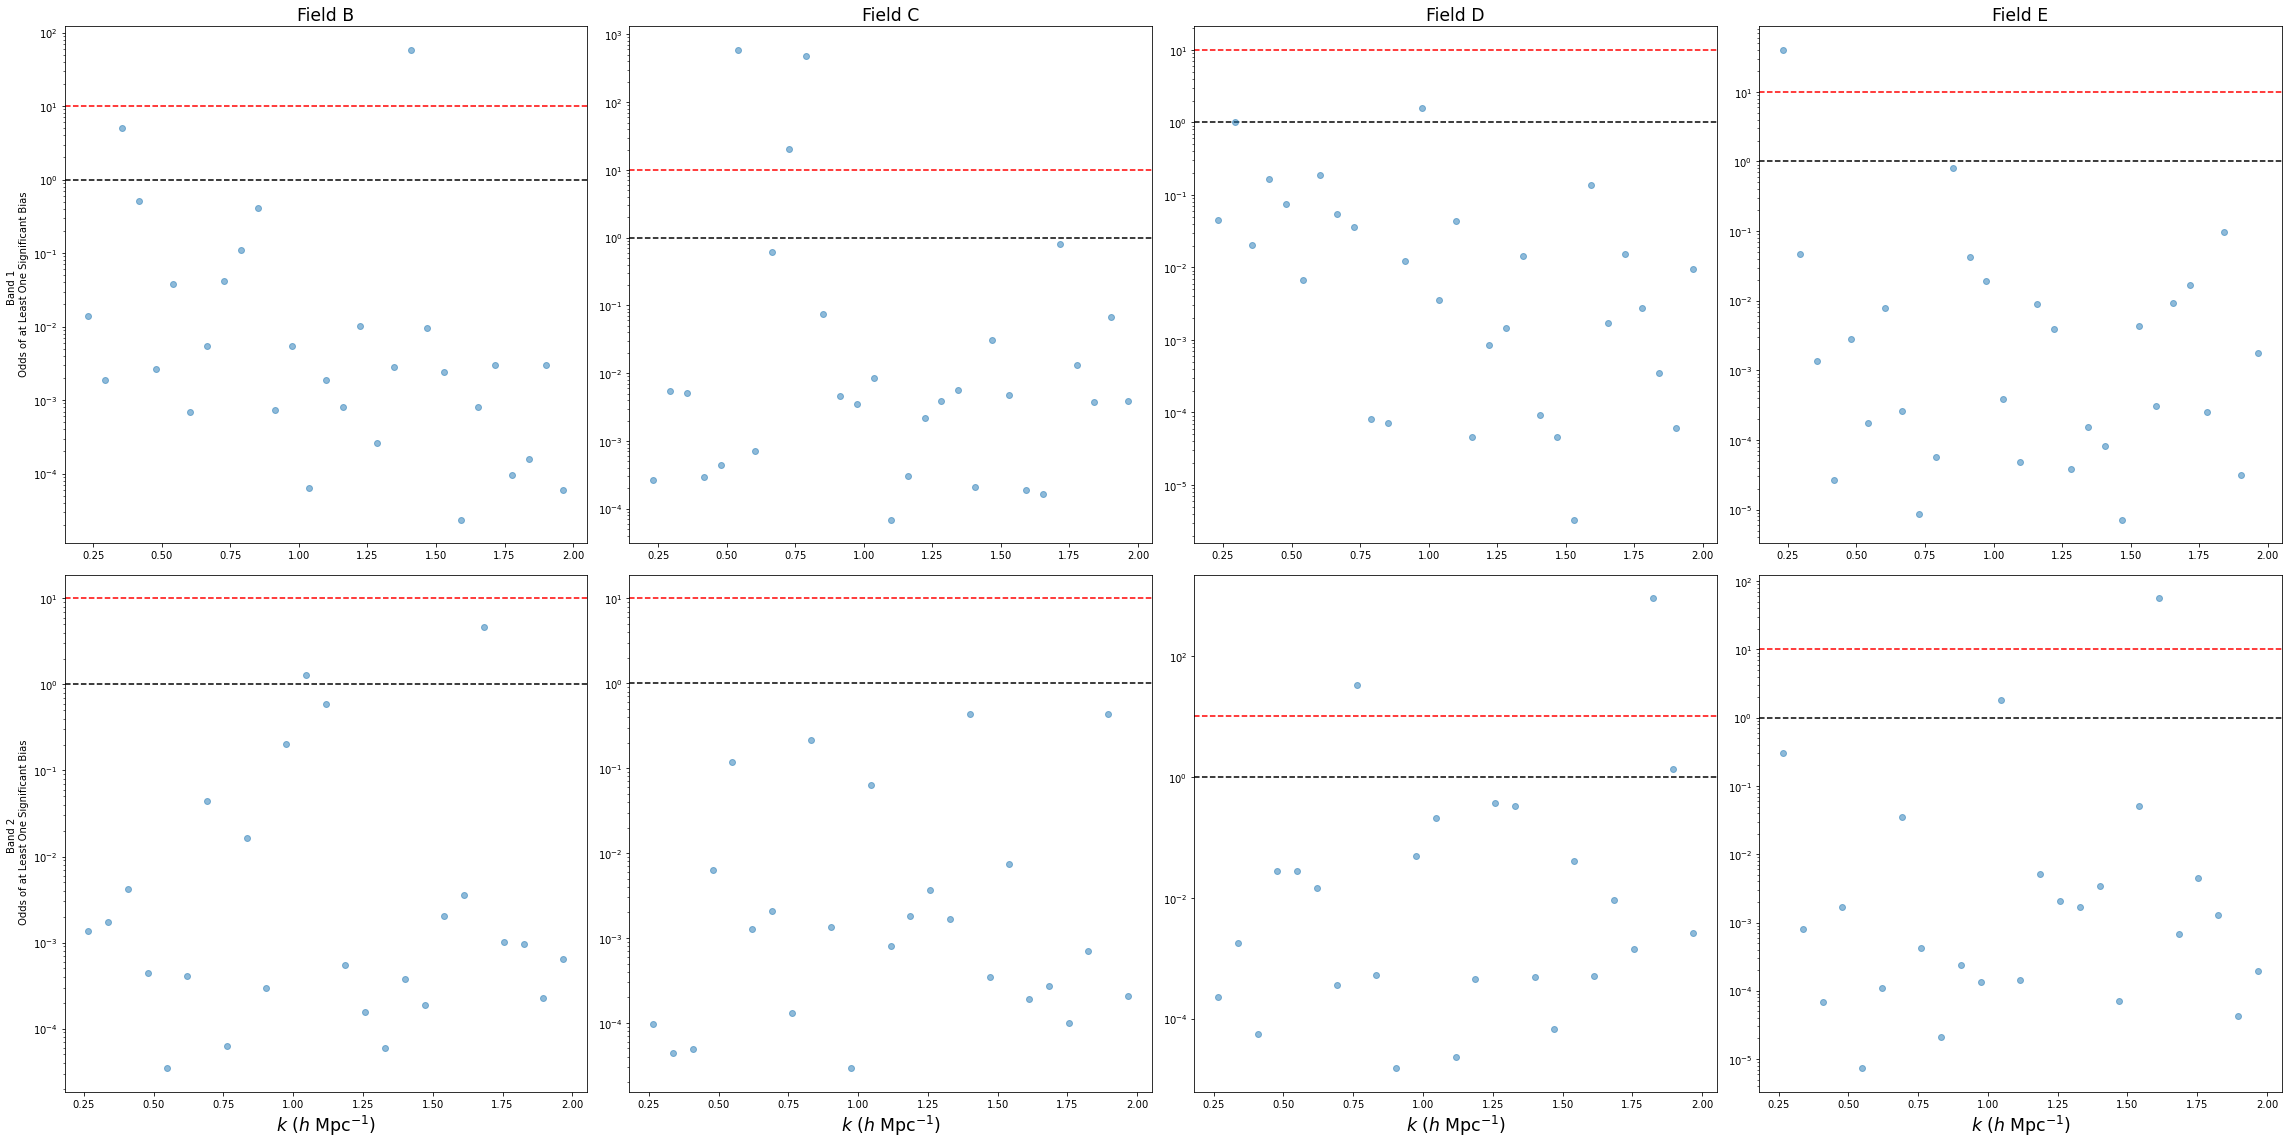

In [30]:
bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1, bppm=0, jk_mode="diag_only", comp='imag',
                       fields='BCDE', bias_prior_mean=6, plot_z=False, outdir="bp_valid_final_plots")

Look for negative biases in the real component

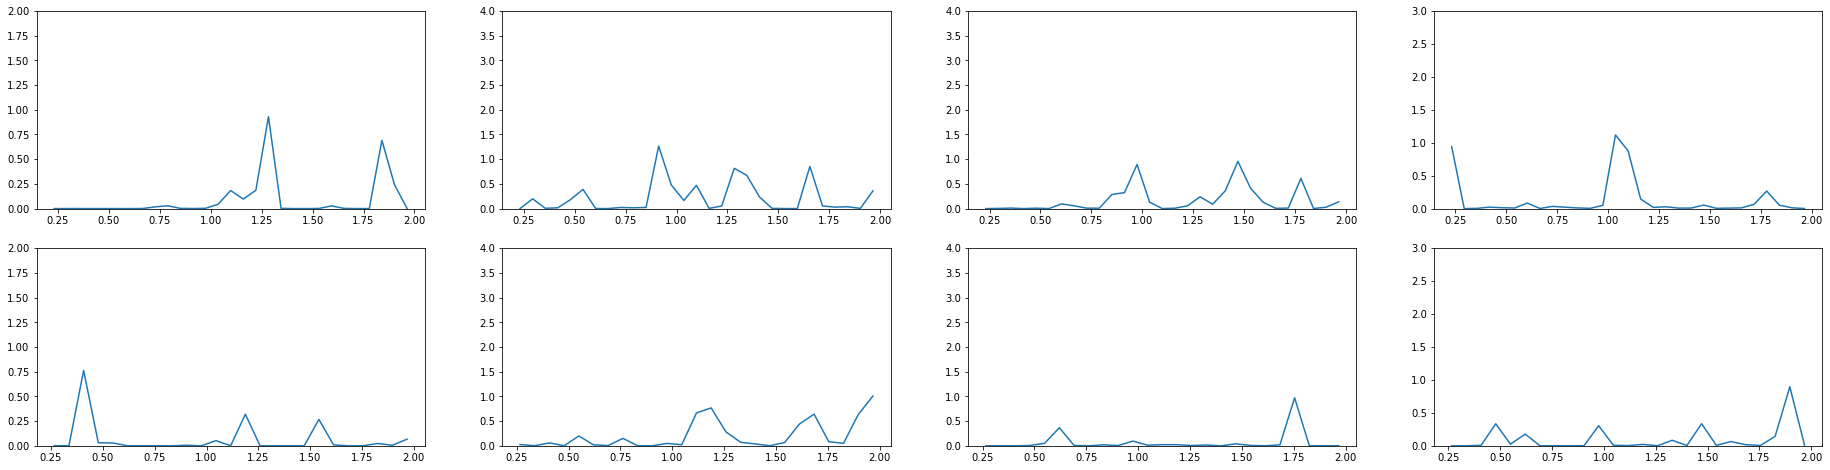

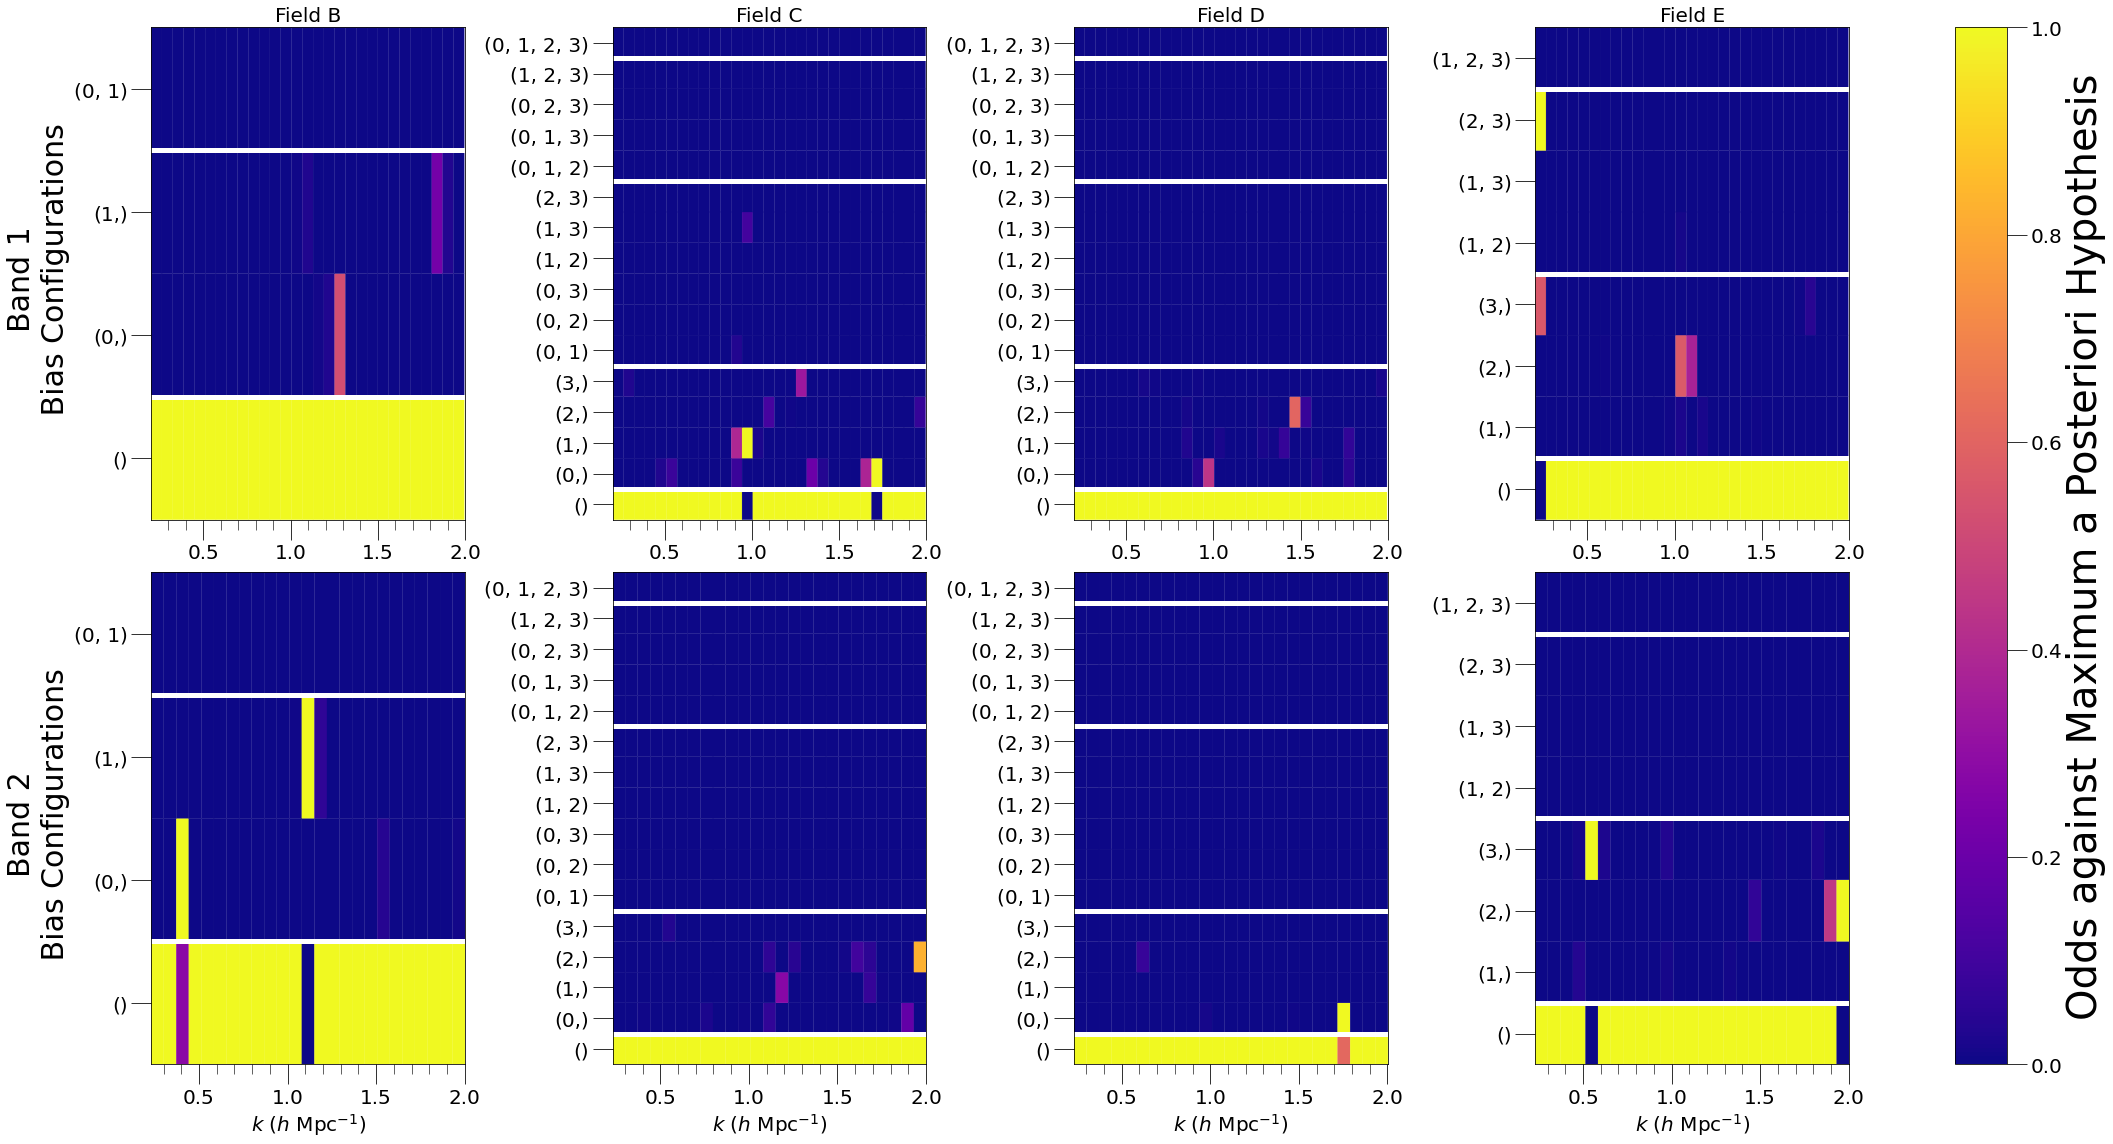

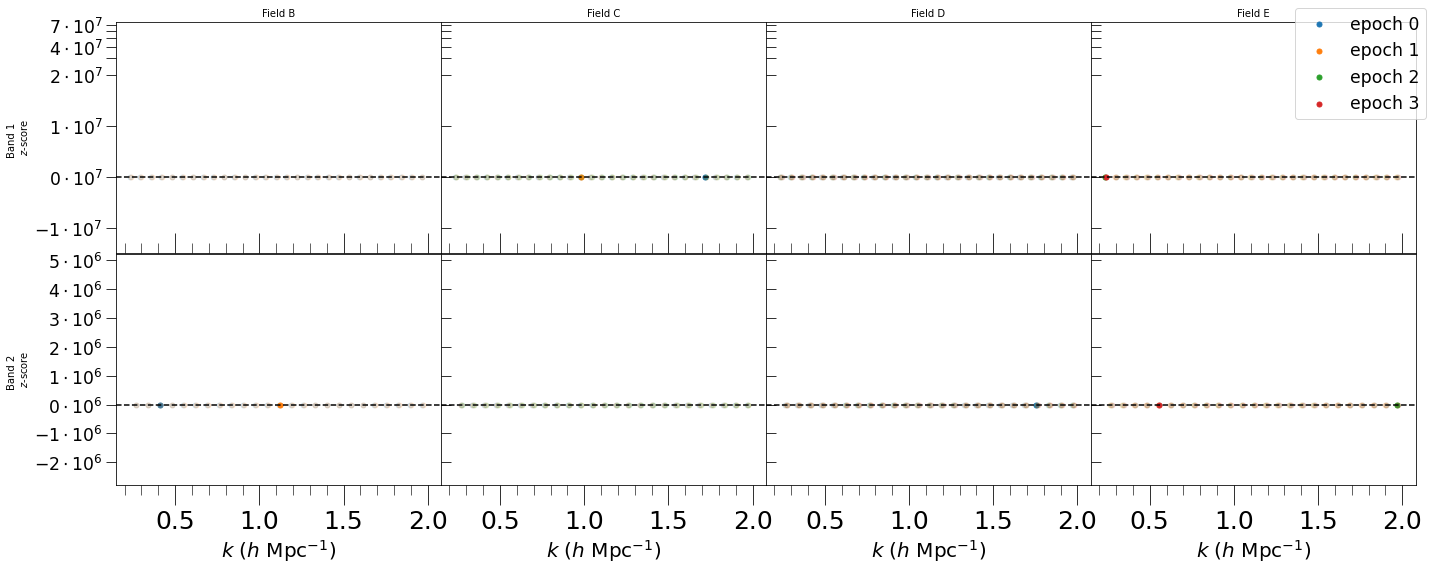

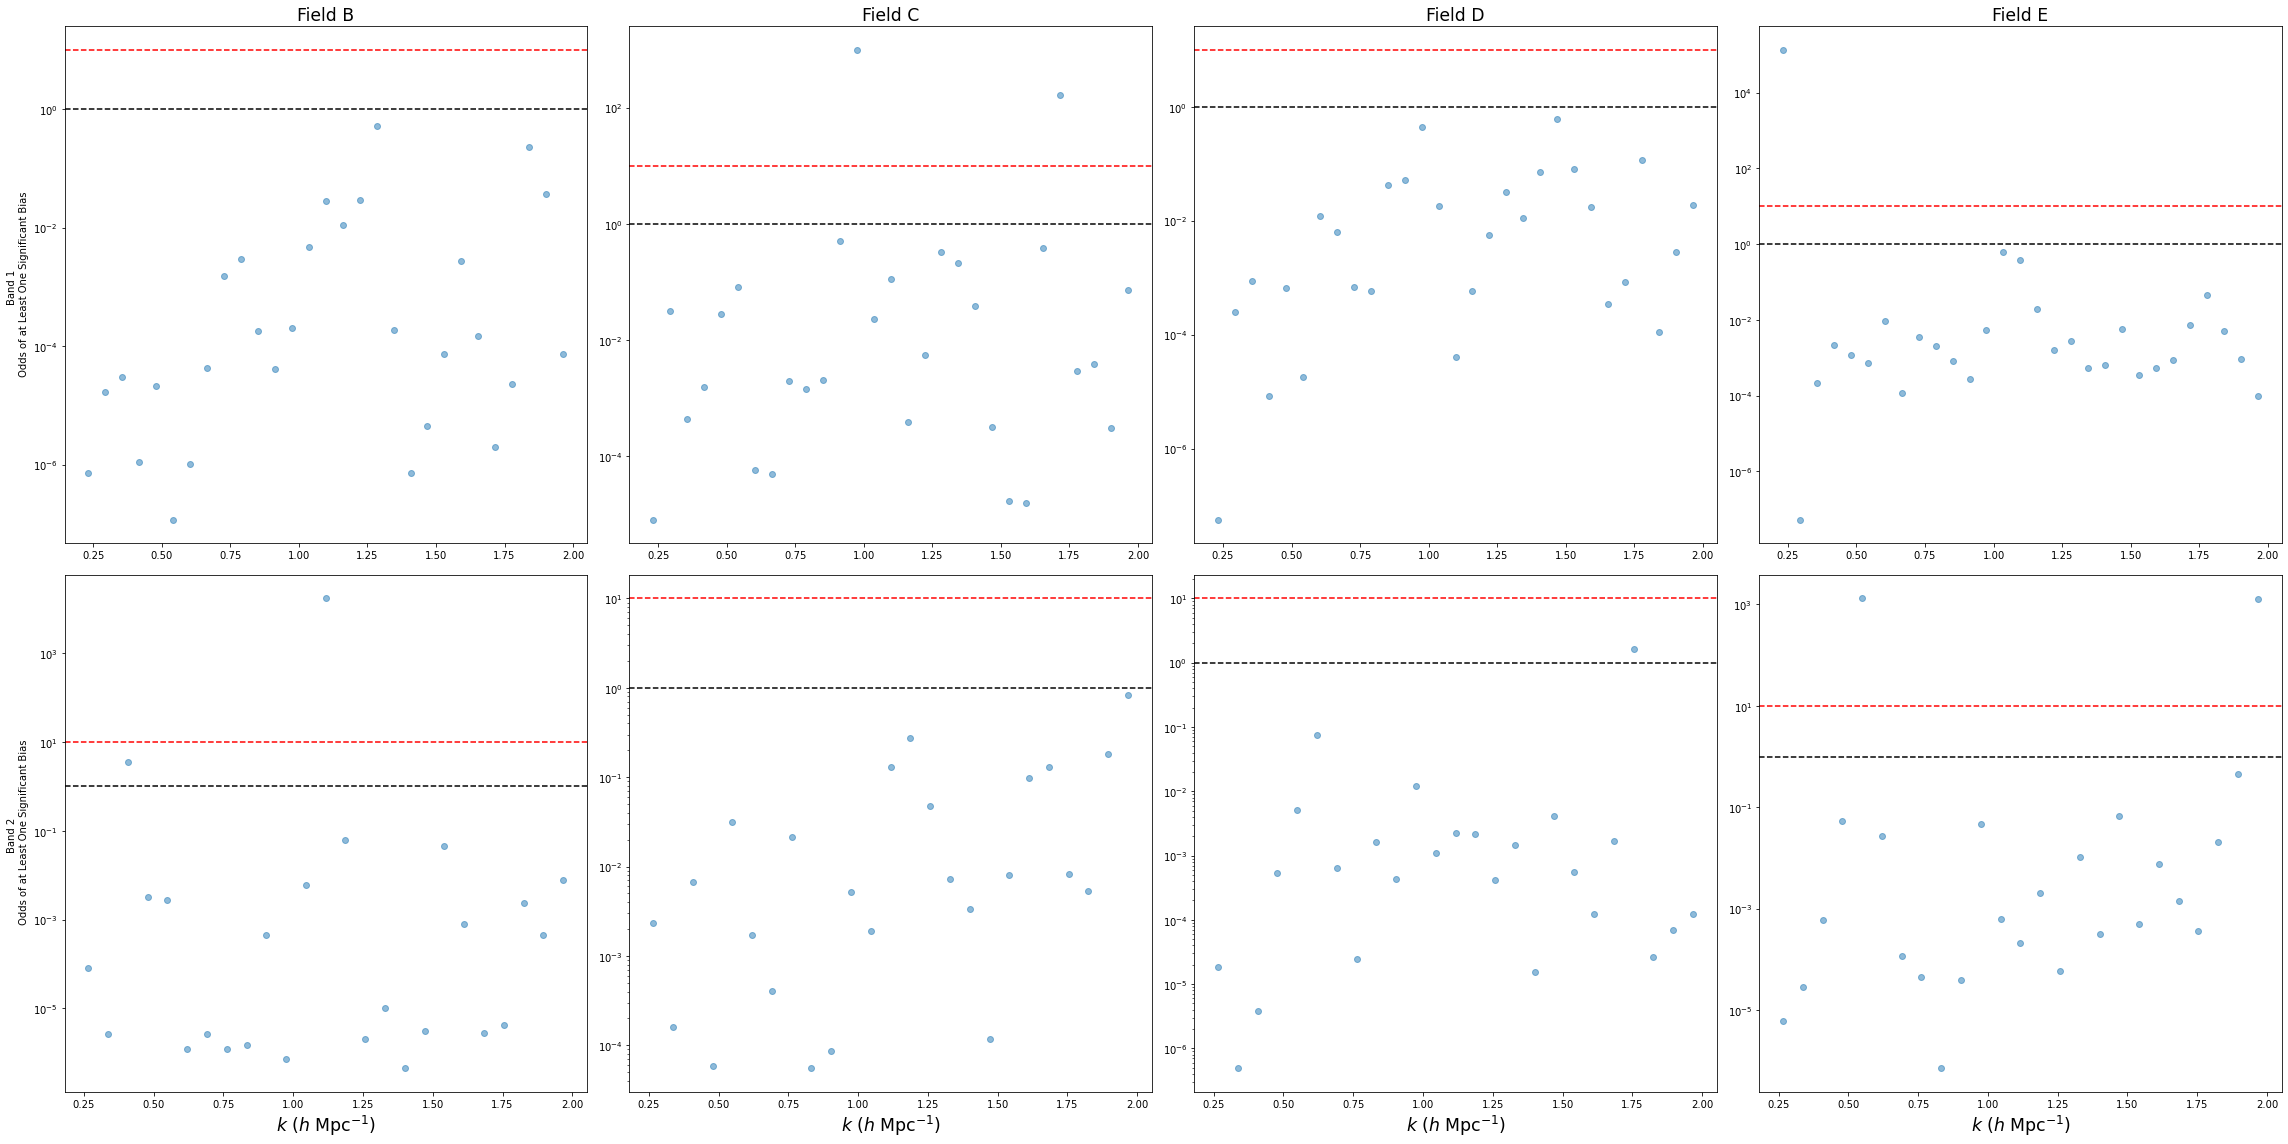

In [31]:
bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1, bppm=0, jk_mode="diag_only",
                       fields='BCDE', bias_prior_mean=-6)

Check for negative biases in the imaginary component

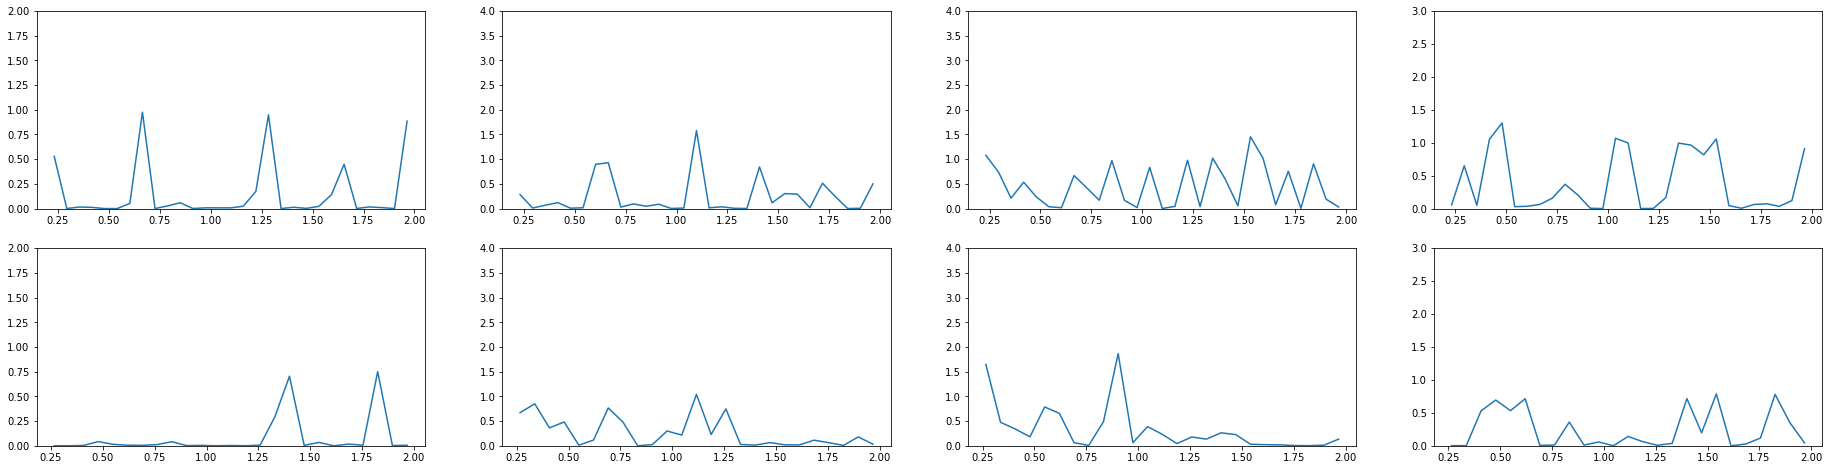

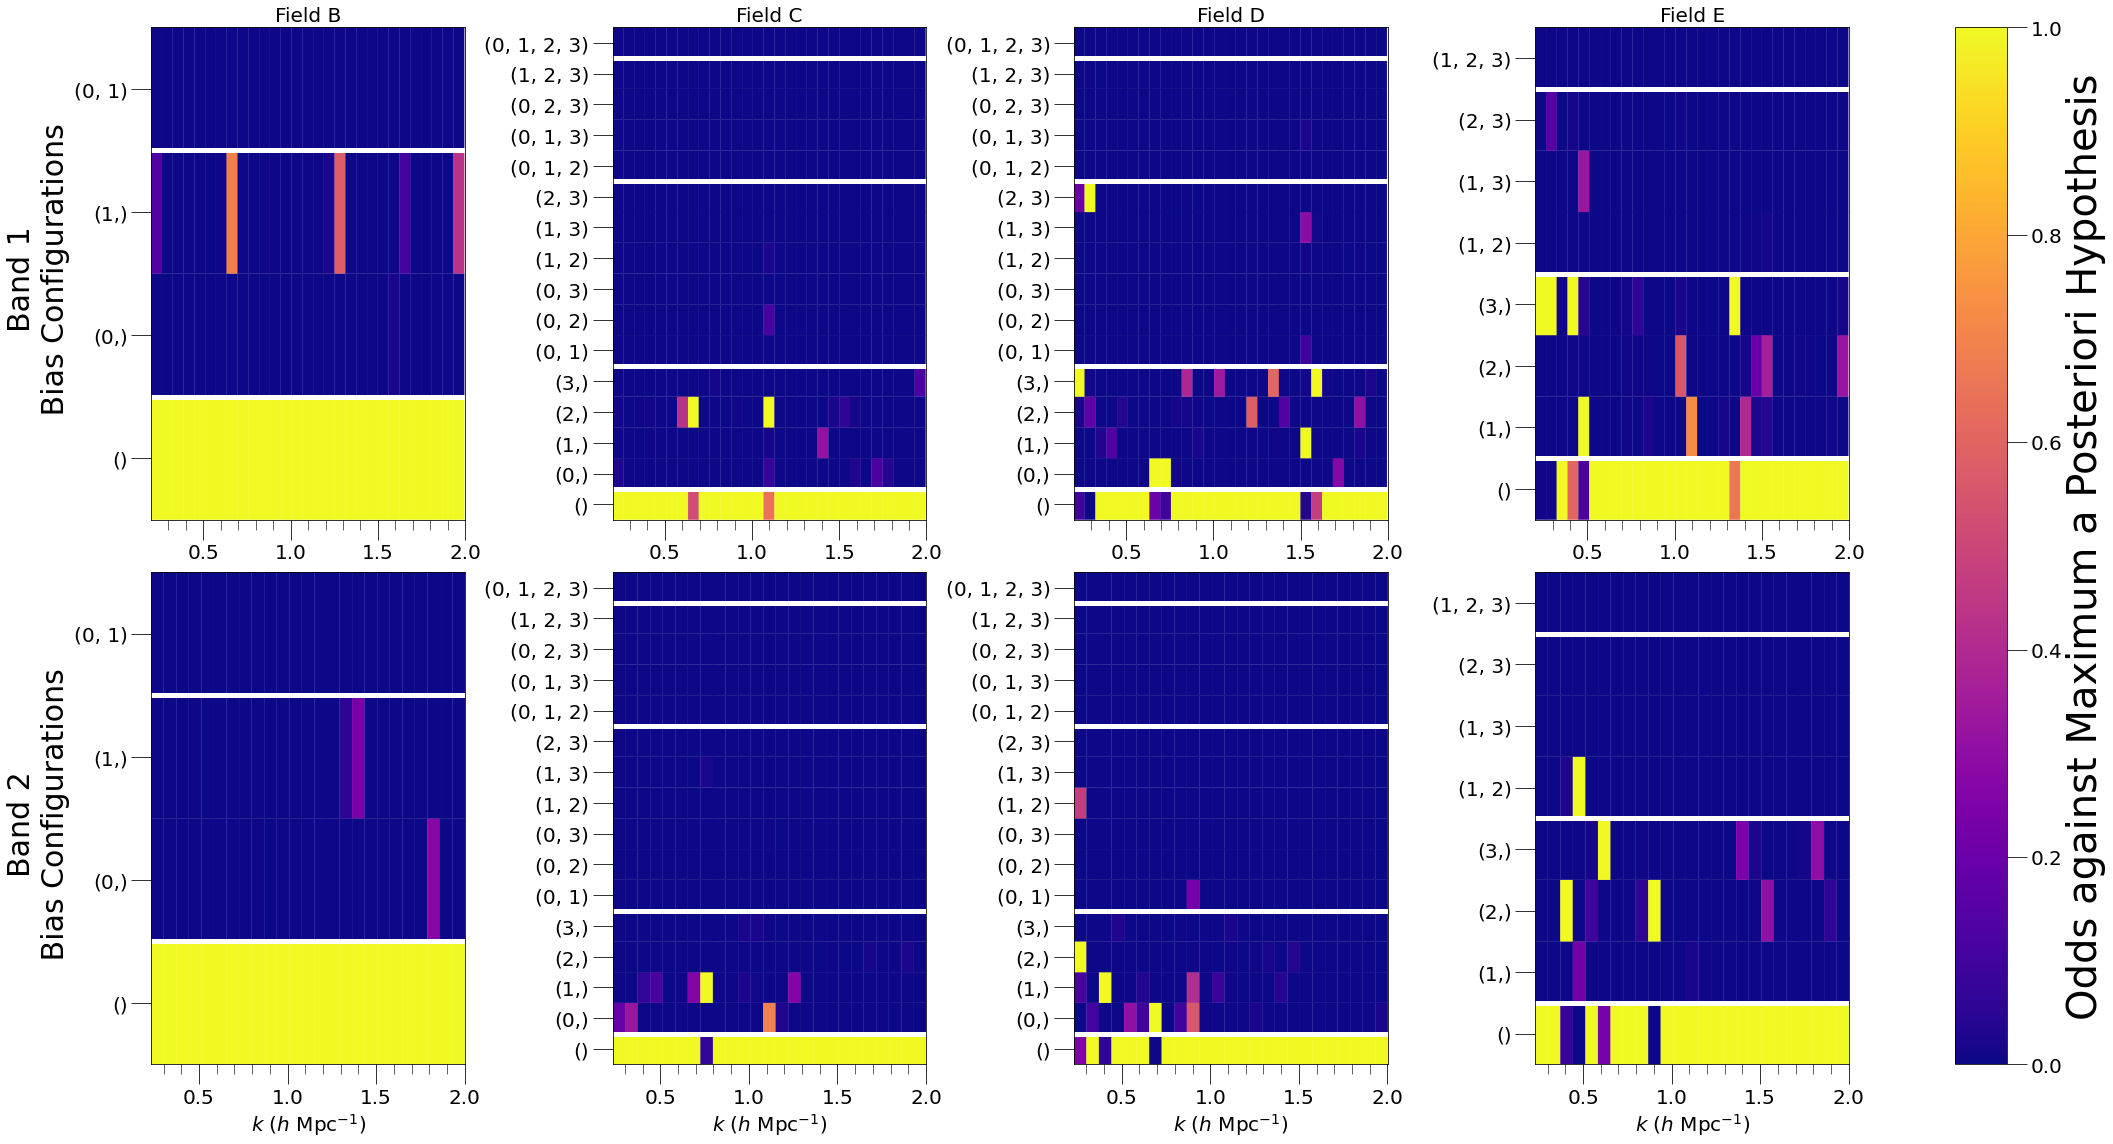

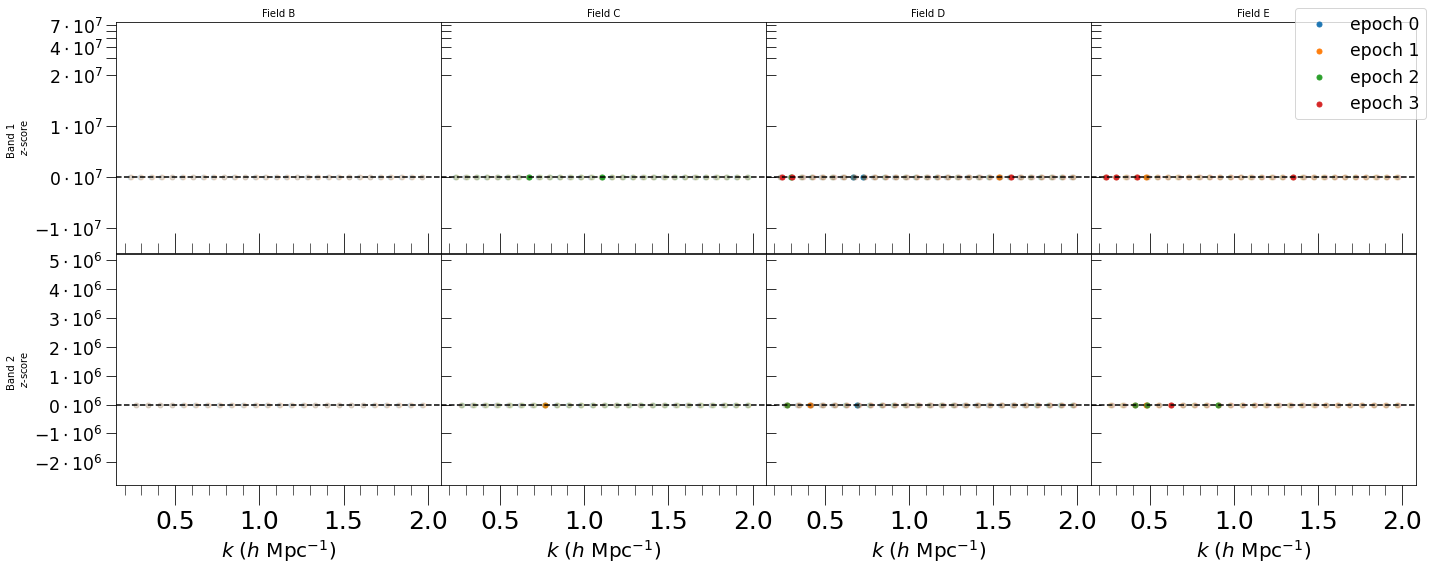

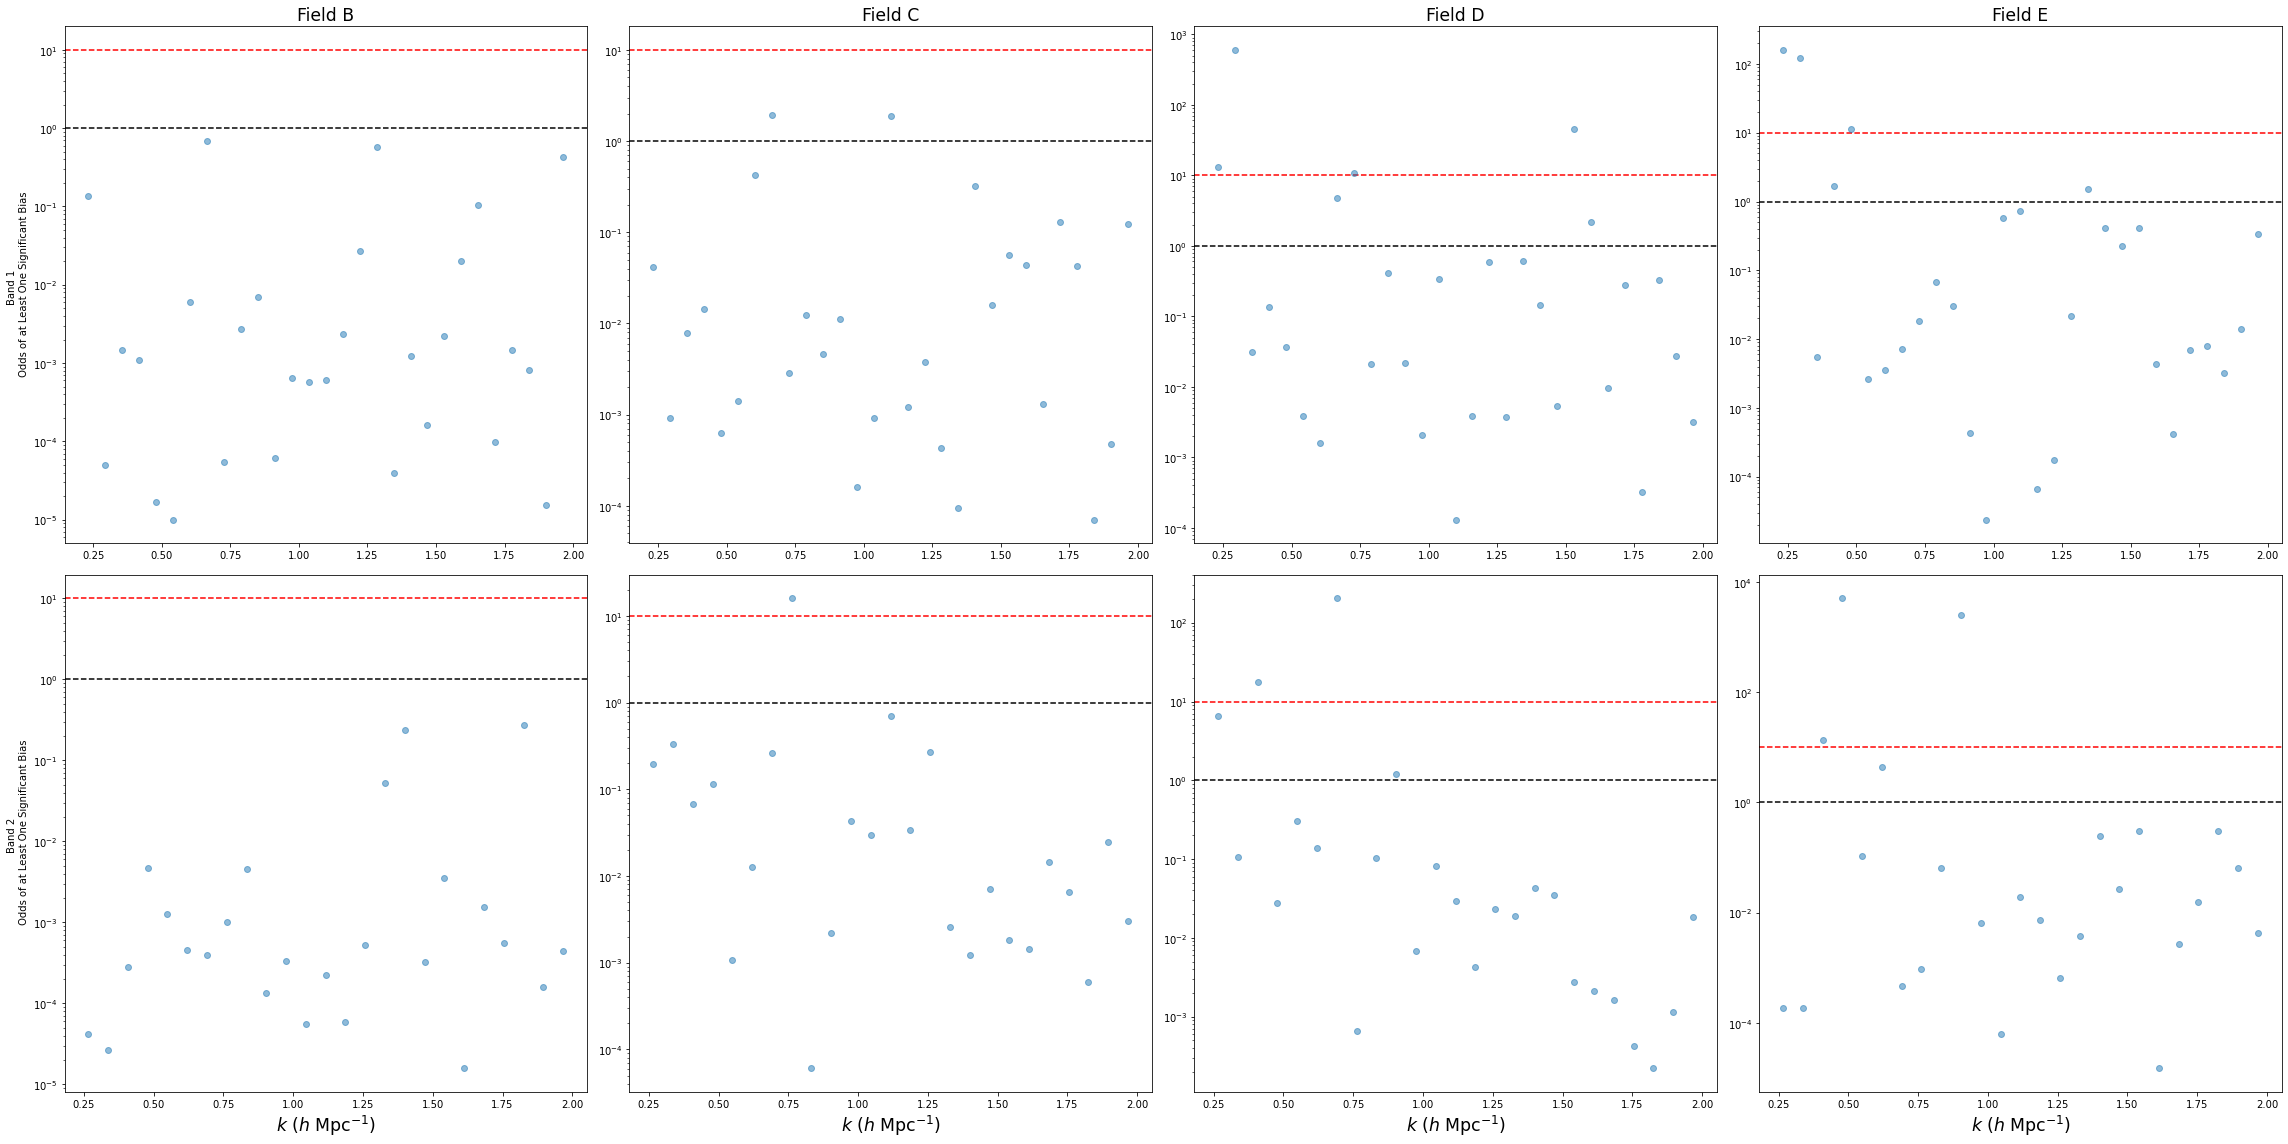

In [32]:
bias_jackknife_wrapper(fade_alpha=0.15, use_I=False, bias_prior_std=1, bppm=0, jk_mode="diag_only",
                       fields='BCDE', bias_prior_mean=-6, comp='imag')

### Make the results plots where the entropy or odds of one significantly biased epoch for all fields for a given band are plotted in the same panel

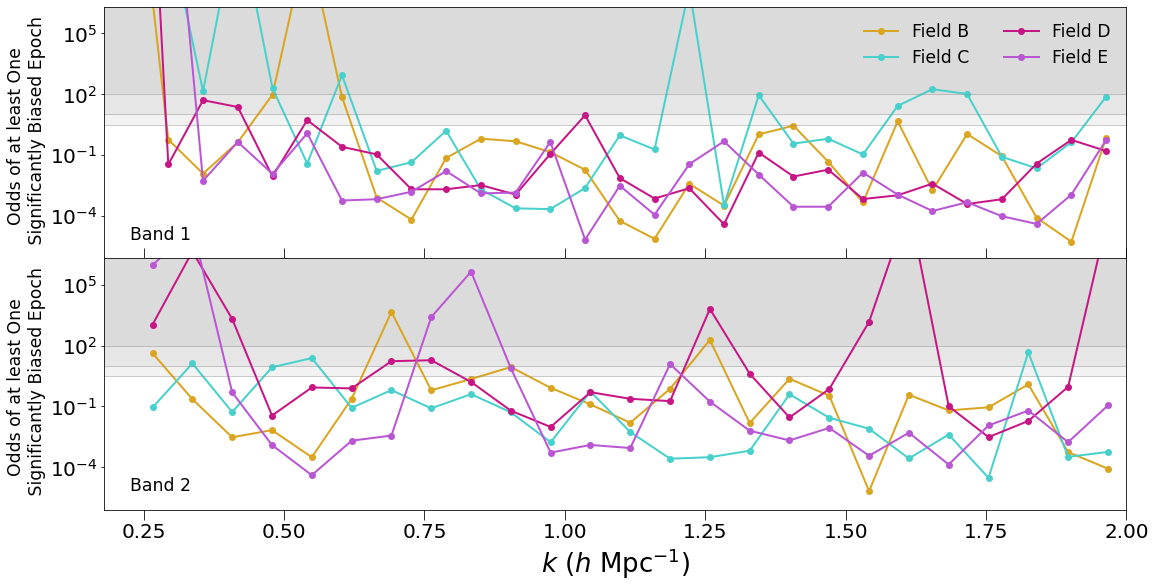

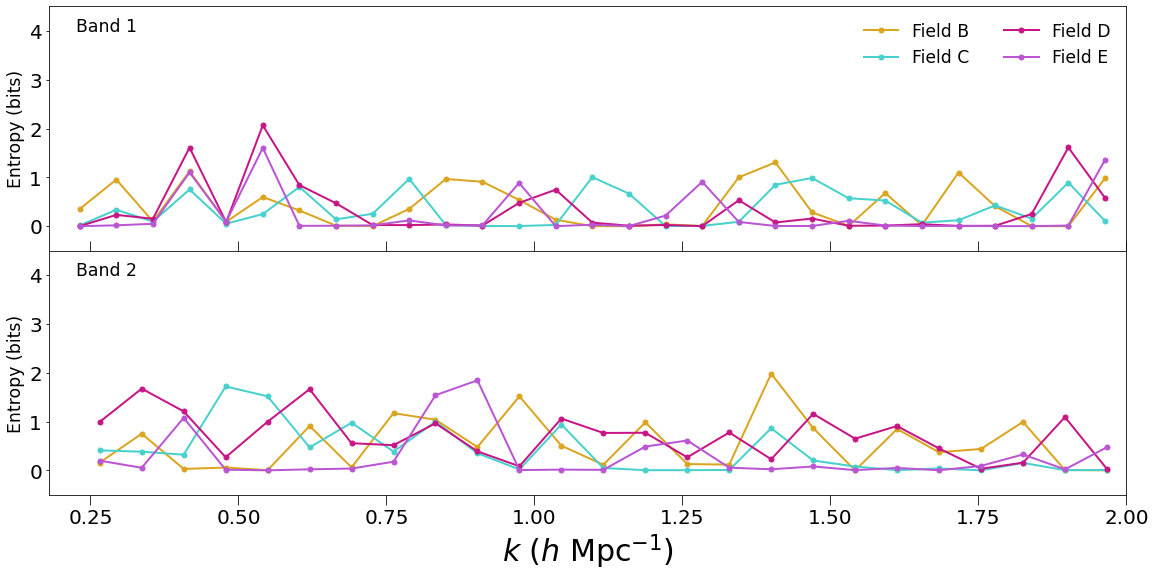

In [33]:
#lst_colors = ['gold', 'cyan', 'deeppink', 'mediumorchid']
lst_colors = ['goldenrod', 'mediumturquoise', 'mediumvioletred', 'mediumorchid']

def niceties(fig, ax, plot_ind, label, ylim, bandx, bandy, band):
    ax[plot_ind].text(x=bandx, y=bandy, s = f"Band {band}", fontsize="xx-large", transform=ax[plot_ind].transAxes)
    ax[plot_ind].set_ylim(ylim)
    ax[plot_ind].set_ylabel(label, fontsize="xx-large")
    ax[plot_ind].set_xlim([0.18, 2.00])
    ax[0].set_xticklabels([])
    ax[0].tick_params(axis='x', direction='in', length=10)
    ax[1].tick_params(axis='x', direction='out', length=10)
    ax[0].set_xlabel(None)
    ax[0].legend(fontsize="xx-large", frameon=False, ncol=2, loc="upper right")
    fig.tight_layout(h_pad=0)
    
    
def two_jk_wrapper(comp="real", bppm=10, stagger=0.004, use_I=False, figsize=(32, 8), alpha=0.5, lw=1.8,
                   bias_prior_std=1, jk_mode="diag_only", fields='BCDE', bias_prior_mean=6, dashz=-200,
                   plot_z=True, mult=True, close=False, print_stats=False, line=False, markersize=15, xwid=2,
                   shade_alpha=0.2, dash=False, shade=True, write=False, marker='.', ticklabelsize=30):
    
    fig, ax = plt.subplots(figsize=figsize, nrows=2, ncols=1)
    ent_fig, ent_ax = plt.subplots(figsize=figsize, nrows=2, ncols=1)
    epoch_res_dirs = get_epoch_res_dirs(True)
    epoch_dict = get_epoch_dict(epoch_res_dirs)
    for plot_ind, band in enumerate('12'):
        for field_ind, field in enumerate('BCDE'):
            epochs = epoch_dict[(band, field)]
            bp_meas_k, stds_k, ks = get_uvp_goodies(int(band), field, 'pk', epoch_res_dirs, epoch_dict,
                                                    epochs=epochs, comp=comp)
            odds_list_k, conc_list_k = get_odds_list_k(ks, stds_k, bp_meas_k, epochs, bppm=bppm, use_I=use_I,
                                                       bias_prior_std=bias_prior_std, jk_mode=jk_mode,
                                                       bias_prior_mean=bias_prior_mean, mult=mult)

            post_list_k = np.array([odds / np.sum(odds) for odds in odds_list_k])

            epoch_combos = get_epoch_combos(epochs)
            
            odds_plot(ax[plot_ind], ks, post_list_k, plot_ind, field_ind, marker=marker,
                      print_stats=print_stats, color=lst_colors[field_ind], label=f"Field {field}",
                      line=line, markersize=markersize, alpha=alpha, lw=lw, dashz=dashz, dash=dash, write=write)
            H_plot(ent_ax[plot_ind], odds_list_k, ks, color=lst_colors[field_ind], markersize=markersize,
                   marker=marker, lw=lw, label=f"Field {field}")
        
        niceties(fig, ax, plot_ind, f"Odds of at least One \n Significantly Biased Epoch",
                 [8e-7, 2e6], 0.025, 0.075, band)
        niceties(ent_fig, ent_ax, plot_ind, "Entropy (bits)", [-0.5, 4.5], 0.025, 0.9, band)
        ent_ax[plot_ind].tick_params(labelsize=ticklabelsize)
        ax[plot_ind].tick_params(labelsize=ticklabelsize)
        ent_ax[1].set_xlabel("$k$ $(h$ Mpc$^{-1})$", fontsize=1.5 * ticklabelsize)
        ax[1].set_xlabel("$k$ $(h$ Mpc$^{-1})$", fontsize=1.3 * ticklabelsize)
        
        if shade:
            ax[plot_ind].axhspan(ymin=10**0.5, ymax=1e10, alpha=shade_alpha, color="gray")
            ax[plot_ind].axhspan(ymin=1e1, ymax=1e10, alpha=shade_alpha, color="gray")
            ax[plot_ind].axhspan(ymin=1e2, ymax=1e10, alpha=shade_alpha, color="gray")
            ax[plot_ind].axhline(10, alpha=0.3, color="gray", lw=1)
            ax[plot_ind].axhline(10**0.5, alpha=0.3, color="gray", lw=1)
            ax[plot_ind].axhline(100, alpha=0.3, color="gray", lw=1)
        ax[0].set_title("")

    fig.savefig("odds_two_panel.pdf")
    ent_fig.savefig("entropy_two_panel.pdf")

two_jk_wrapper(use_I=False, bias_prior_std=1, bppm=0, jk_mode="diag_only", dashz=-200, shade_alpha=0.1,
               bias_prior_mean=6, figsize=(16, 8), line=True, alpha=1, lw=2, markersize=10, write=True,
               ticklabelsize=20)

Wrapper to make actual validation plots used in paper

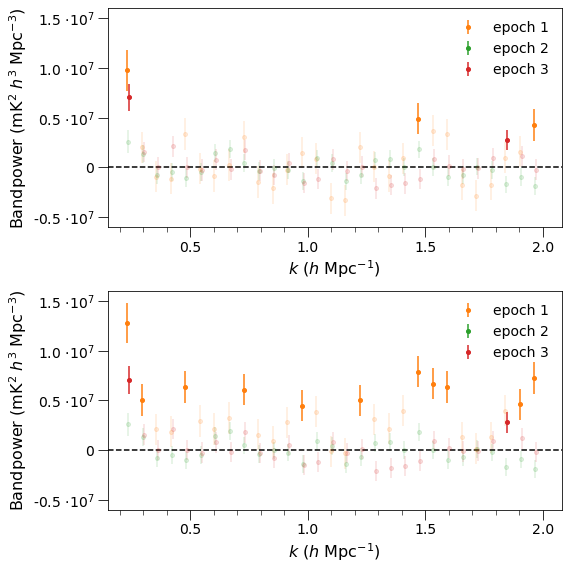

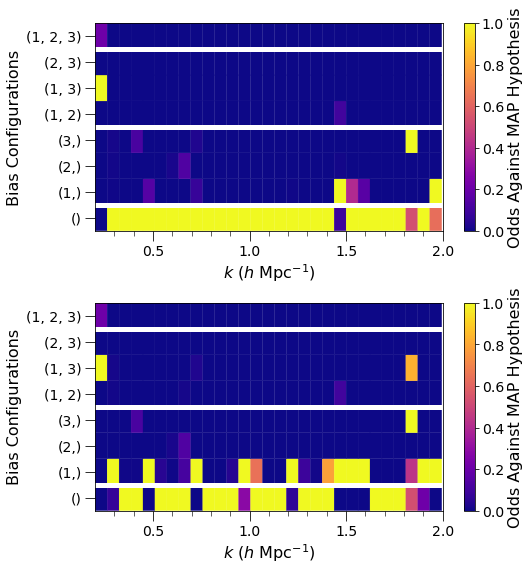

In [34]:


def val_wrap(band='1', field='E', comp='real', bppm=0, use_I=False, bias_prior_std=1, jk_mode="diag_only",
             bias_prior_mean=6, mult=True, add_val=1e6, stagger=0.004, fade_alpha=0.15, kticks=0.25,
             ticksize=12, labelsize=14):
    
    fig, ax = plt.subplots(figsize=(8, 8), nrows=2)
    fig2, ax2 = plt.subplots(figsize=(8, 8), nrows=2)
    epoch_res_dirs = get_epoch_res_dirs(False)
    epoch_dict = get_epoch_dict(epoch_res_dirs)
    epochs = epoch_dict[(band, field)]
    epoch_combos = get_epoch_combos(epochs)
    bp_meas_k, stds_k, ks = get_uvp_goodies(int(band), field, 'pk', epoch_res_dirs, epoch_dict, epochs=epochs,
                                            comp=comp)
    kticks = np.arange(kticks, 2 + kticks, kticks)
    yticks = np.arange(-0.5, 2, 0.5)
    for add in [0, 1]:
        if add:
            bp_meas_k[0] += add_val
        odds_list_k, conc_list_k = get_odds_list_k(ks, stds_k, bp_meas_k, epochs, bppm=bppm, use_I=use_I,
                                                   bias_prior_std=bias_prior_std, jk_mode=jk_mode,
                                                   bias_prior_mean=bias_prior_mean, mult=mult)
        

        bp_plot(ax[add], bp_meas_k / 1e7, stds_k / 1e7, ks, odds_list_k, epochs, conc_list_k,
                    epoch_combos, 1, 2, bppm=bppm, stagger=stagger, fade_alpha=fade_alpha,
                    plot_z=False, fontsize=ticksize, dat=False)
        ax[add].set_ylabel("Bandpower (mK$^2$ $h^3$ Mpc$^{-3}$)", fontsize=labelsize)
        ax[add].legend(frameon=False, loc="upper right", fontsize=ticksize)

        ax[add].set_yticks(yticks)
        yticklabels = [r'%.1f $ \cdot 10^7$' % tick for tick in yticks]
        yticklabels[1] = '0'
        ax[add].set_yticklabels(yticklabels)
        ax[add].set_ylim([-0.6, 1.6])
        
        
        cax = odds_plot_2d(ax2[add], epoch_combos, ks, odds_list_k, 1,
                           2, print_stats=False, vmin=0)
        ax[add].set_xticks(kticks)
        ax2[add].set_xticks(kticks)
        cbar = fig.colorbar(cax, ax=ax2[add])
        cbar.ax.tick_params(labelsize=ticksize)
        cbar.set_label("Odds Against MAP Hypothesis", fontsize=labelsize)
        ax2[add].set_ylabel("Bias Configurations", fontsize=labelsize)
    for ax_ob in ax.flatten():
        ax_ob.set_xlabel("$k$ $(h$ Mpc$^{-1})$",fontsize=labelsize)
        ax_ob.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax_ob.tick_params(labelsize=ticksize)
        ax_ob.tick_params(which='minor', length=5)
    for ax_ob in ax2.flatten():
        ax_ob.set_xlabel("$k$ $(h$ Mpc$^{-1})$",fontsize=labelsize)
        ax_ob.xaxis.set_minor_locator(AutoMinorLocator(5))
        ax_ob.tick_params(labelsize=ticksize)
        ax_ob.tick_params(which='minor', length=5)
        
    fig.tight_layout()
    fig.savefig("bp_valid_final_plots/valid_bp.pdf")
    fig2.savefig("bp_valid_final_plots/valid_stoplight.pdf")
val_wrap(add_val=3e6, ticksize=14, kticks=0.5, labelsize=16)